# EI_Hurst

Lydia Sochan and Alex Weber  
February 15, 2025

In [ ]:
# First, let's load our packages.
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths

corrplot 0.92 loaded


Attaching package: 'Hmisc'

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units

Loading required package: viridisLite


Attaching package: 'nlme'

The following object is masked from 'package:dplyr':

    collapse


Attaching package: 'corrr'

The following object is masked from 'package:lsr':

    correlate

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: Matrix

Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack

Loaded glmnet 4.1-8


Attaching package: 'psych'

The following object is masked from 'package:Hmisc':

    describe

The following objects are masked from 'package:ggplot2':

    %+%, alpha

Loading required package: lme4

Attaching package: 'lme4'

The following object is masked from 'package:nlme':

    lmList

The following object is masked from 'package:rio':

    factorize


Attaching package: 'lmerTest'

The following object is masked from 'package:lme4':

    lmer

The following object is masked from 'package:stats':

    step

In [ ]:
### LOAD DATA

# Base directory
base_dir <- "../Data/participant_measures/"

# Create filenames
filenames <- paste0(base_dir, "sub-Pilot", sprintf("%02d", 1:26), "_EI_Hurst_Measures_Expanded.tsv")

# Function to read and process a single file
read_and_process <- function(filename) {
  # Read the file
  data <- import(filename, fill = T)

  # Extract the subject number from the filename
  subject_number <- gsub(".*sub-Pilot(\\d+).*", "\\1", filename)

  # Add the subject number column
  data <- mutate(data, Subject = subject_number)
  data <- data %>% select(Subject, everything())
  # This column appears to have a lot of NAs
  data <- data %>% select(!c(Rest_GABA_Gannet_tCr, Movie_GABA_Gannet_tCr))

  return(data)
}

# Apply the function to each file
list_of_dataframes <- lapply(filenames, read_and_process)

# Combine all dataframes into one and reformat some columns
df <- bind_rows(list_of_dataframes)
df$Subject <- as.numeric(df$Subject) # Change Subject column to numeric
num_subjects <- length(df$Subject) # Count the number of subjects

# GABA+ from Osprey
df <- df %>%
  select(Subject, Rest_Glu, Movie_Glu, Rest_GABA, Movie_GABA, Rest_GABAplus, Movie_GABAplus, Rest_GABA_Gannet, Movie_GABA_Gannet, Rest_Hurst_FullFreq, Movie_Hurst_FullFreq, Rest_MeanFD, Movie_MeanFD, Rest_FWHM_SLASER, Rest_FWHM_Osprey, Movie_FWHM_Osprey, Movie_FWHM_SLASER, Rest_Glx, Movie_Glx, Rest_Glx_tCr, Movie_Glx_tCr, Rest_GABAplus_tCr, Movie_GABAplus_tCr) %>%
  rename(Rest_GABAGannet = Rest_GABA_Gannet, Movie_GABAGannet = Movie_GABA_Gannet)

tcr <- T
if (tcr == T) {
  df <- subset(df, select = -c(Rest_Glx, Movie_Glx))
  df$Rest_Glx <- df$Rest_Glx_tCr
  df$Movie_Glx <- df$Movie_Glx_tCr
  df <- subset(df, select = -c(Rest_Glx_tCr, Movie_Glx_tCr))
  df <- subset(df, select = -c(Rest_GABAplus, Movie_GABAplus))
  df$Rest_GABAplus <- df$Rest_GABAplus_tCr
  df$Movie_GABAplus <- df$Movie_GABAplus_tCr
  df <- subset(df, select = -c(Rest_GABAplus_tCr, Movie_GABAplus_tCr))
}

In [ ]:
# Load additional Hurst measures
# Base directory
base_dir <- "../Data/participant_measures/add_hurst_data/"

# Create filenames
filenames <- paste0(base_dir, "sub-Pilot", sprintf("%02d", 1:26), "_Add_Hurst.tsv")

# Function to read and process a single file
read_and_process <- function(filename) {
  # Read the file
  data <- import(filename, fill = T)

  # Extract the subject number from the filename
  subject_number <- gsub(".*sub-Pilot(\\d+).*", "\\1", filename)

  # Add the subject number column
  data <- mutate(data, Subject = subject_number)
  data <- data %>% select(Subject, everything())
  # This column appears to have a lot of NAs

  return(data)
}

# Apply the function to each file
list_of_dataframes <- lapply(filenames, read_and_process)

# Combine all dataframes into one and reformat some columns
df_additionalHurst <- bind_rows(list_of_dataframes)
df_additionalHurst$Subject <- as.numeric(df_additionalHurst$Subject)

# Keep only RS (for now)

df_RS <- df_additionalHurst %>% select(Subject, Rest_RS, Movie_RS)

In [ ]:
df <- full_join(df, df_RS, by = "Subject")
## only include selected participants
df <- df %>% dplyr::filter(Rest_MeanFD <= 0.15, Movie_MeanFD <= 0.15, Rest_FWHM_SLASER <= 10, Rest_FWHM_Osprey <= 10, Movie_FWHM_Osprey <= 10, Movie_FWHM_SLASER <= 10)

# Subject Demographics

We collected age, sex and handedness:

In [ ]:
# Let's start by compiling our dataframe with subject demographics. We create a function to calculate age at scan from birthday and scan date.

# Subject Info
subjects <- read.csv("../Data/participant_measures/SubjectInfo.csv")
# age <- function(dob, age.day = today(), units = "years", floor = TRUE) {
#   calc.age <- lubridate::interval(dob, age.day) / lubridate::duration(num = 1, units = units)
#   if (floor) {
#     return(as.integer(floor(calc.age)))
#   }
#   return(calc.age)
# }
# year <- substring(subjects$DOB, 7, 10)
# month <- substring(subjects$DOB, 4, 5)
# day <- substring(subjects$DOB, 1, 2)
orig_subjects <- subjects
orig_subjects$Age <- as.numeric(interval(dmy(orig_subjects$DOB), dmy(orig_subjects$DOS)) / years(1))

Of the original 26 subjects we scanned:  
mean age = 29.7172825  
age range = 20.969863, 53.3961749  
number of males = 11

In [ ]:
subjects <- subjects[c(1:2, 4, 6:7, 9:13, 15:16, 18:20, 22:24, 26), ]
num_subjects <- 19
year <- substring(subjects$DOB, 7, 10)
month <- substring(subjects$DOB, 4, 5)
day <- substring(subjects$DOB, 1, 2)
#subjects$DOB <- paste0(year, "-", month, "-", day)
subjects$Age <- as.numeric(interval(dmy(subjects$DOB), dmy(subjects$DOS)) / years(1))
subjects$Subject <- c(1:2, 4, 6:7, 9:13, 15:16, 18:20, 22:24, 26)
subs_clean <- dplyr::select(subjects, Subject, Age, Sex, Handedness)

color.picker.sex <- function(z) {
  if (z == "M") {
    return("lightblue")
  } else if (z == "F") {
    return("pink")
  } else {
    return("white")
  }
}
color.picker.hand <- function(z) {
  if (z == "L") {
    return("red")
  } else if (z == "R") {
    return("darkolivegreen1")
  } else {
    return("white")
  }
}

sub_dem <- formattable(subs_clean, list(
  Sex = formatter("span",
    style = x ~ style(
      display = "block",
      "border-radius" = "4px",
      "padding-right" = "4px",
      "background-color" = sapply(x, color.picker.sex)
    )
  ),
  Handedness = formatter("span",
    style = x ~ style(
      display = "block",
      "border-radius" = "4px",
      "padding-right" = "4px",
      "color" = sapply(x, color.picker.hand)
    )
  )
))
sub_dem

Here are some summary statistics, grouped by sex, looking at age:

In [ ]:
sub_dem <- as.data.frame(sub_dem)
sub_dem <- na.omit(sub_dem)
sub_dem$Sex <- as.factor(sub_dem$Sex)
## exclude participants with insufficient MRS/fMRI quality metrics
print(paste0("Mean: ", mean(sub_dem$Age), " SD: ", sd(sub_dem$Age)))

[1] "Mean: 30.0837542992897 SD: 8.67192921721759"

  Sex      n    mean      sd     median         IQR        min        max
  ----- ---- ------- ------- ---------- ----------- ---------- ----------
  F       10   27.36    5.12   26.82871    3.566596   21.70137   39.30874
  M        9   33.11   10.96   29.67213   13.940295   21.28962   53.39617



    Welch Two Sample t-test

data:  sub_dem_f$Age and sub_dem_m$Age
t = -1.4389, df = 11.078, p-value = 0.1778
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -14.537894   3.037636
sample estimates:
mean of x mean of y 
 27.36001  33.11014 

And a look at the distribution:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

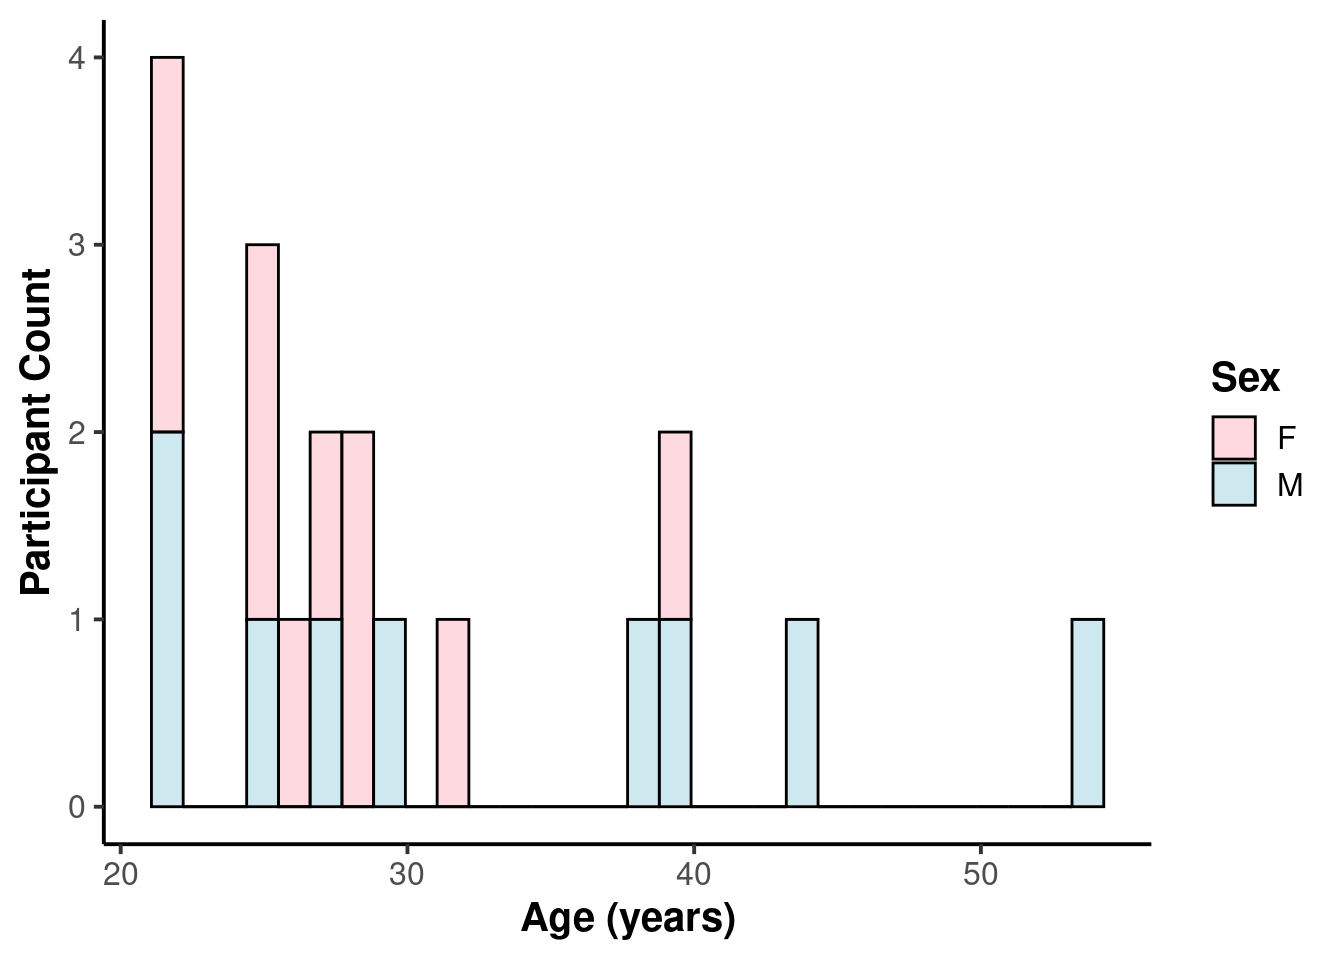

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

png 
  2 

In [ ]:
(sub_dem_plot <- ggplot(sub_dem, aes(x = Age, group = Sex, fill = Sex)) +
  geom_histogram(position = "stack", alpha = 0.6, color = "black", boundary = 10) +
  theme_classic(base_size = 15) +
  scale_fill_manual(values = c("pink", "lightblue")) +
  theme(
    strip.background = element_blank(), strip.text.x = element_text(size = 15, face = "bold"),
    axis.title = element_text(face = "bold"), legend.title = element_text(face = "bold")
  ) +
  ylab("Participant Count") +
  xlab("Age (years)"))

# Quality Assurance

In [ ]:
# We are selecting Hurst values calculated from the full frequency range, rather than the bandpass-filtered results:
fullfreq_hurst <- T
if (fullfreq_hurst == T) {
  df$Rest_Hurst <- df$Rest_Hurst_FullFreq
  df$Movie_Hurst <- df$Movie_Hurst_FullFreq
}

Before calculating our results, let’s look at the quality of our data. Let’s start with full-width half-maximum, a quality measure for spectroscopy.

In [ ]:
## only include selected participants
fwhm_df <- dplyr::select(df, grep("FWHM", names(df)))
fwhm_df <- fwhm_df %>% rename(Rest_FWHM_MEGAPRESS = Rest_FWHM_Osprey, Movie_FWHM_MEGAPRESS = Movie_FWHM_Osprey)
fwhm_df <- reshape2::melt(fwhm_df)

No id variables; using all as measure variables

Summary statistics:

In [ ]:
knitr::kable(fwhm_df %>% group_by(Condition, Method) %>% summarise(mean = round(mean(FWHM), 2), sd = round(sd(FWHM), 2)))

`summarise()` has grouped output by 'Condition'. You can override using the
`.groups` argument.

  Condition   Method        mean     sd
  ----------- ----------- ------ ------
  Rest        MEGAPRESS     7.02   0.70
  Rest        SLASER        8.52   0.70
  Movie       MEGAPRESS     6.98   0.86
  Movie       SLASER        8.37   0.65


Number of subjects lost: 7

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

(`geom_bar()`).

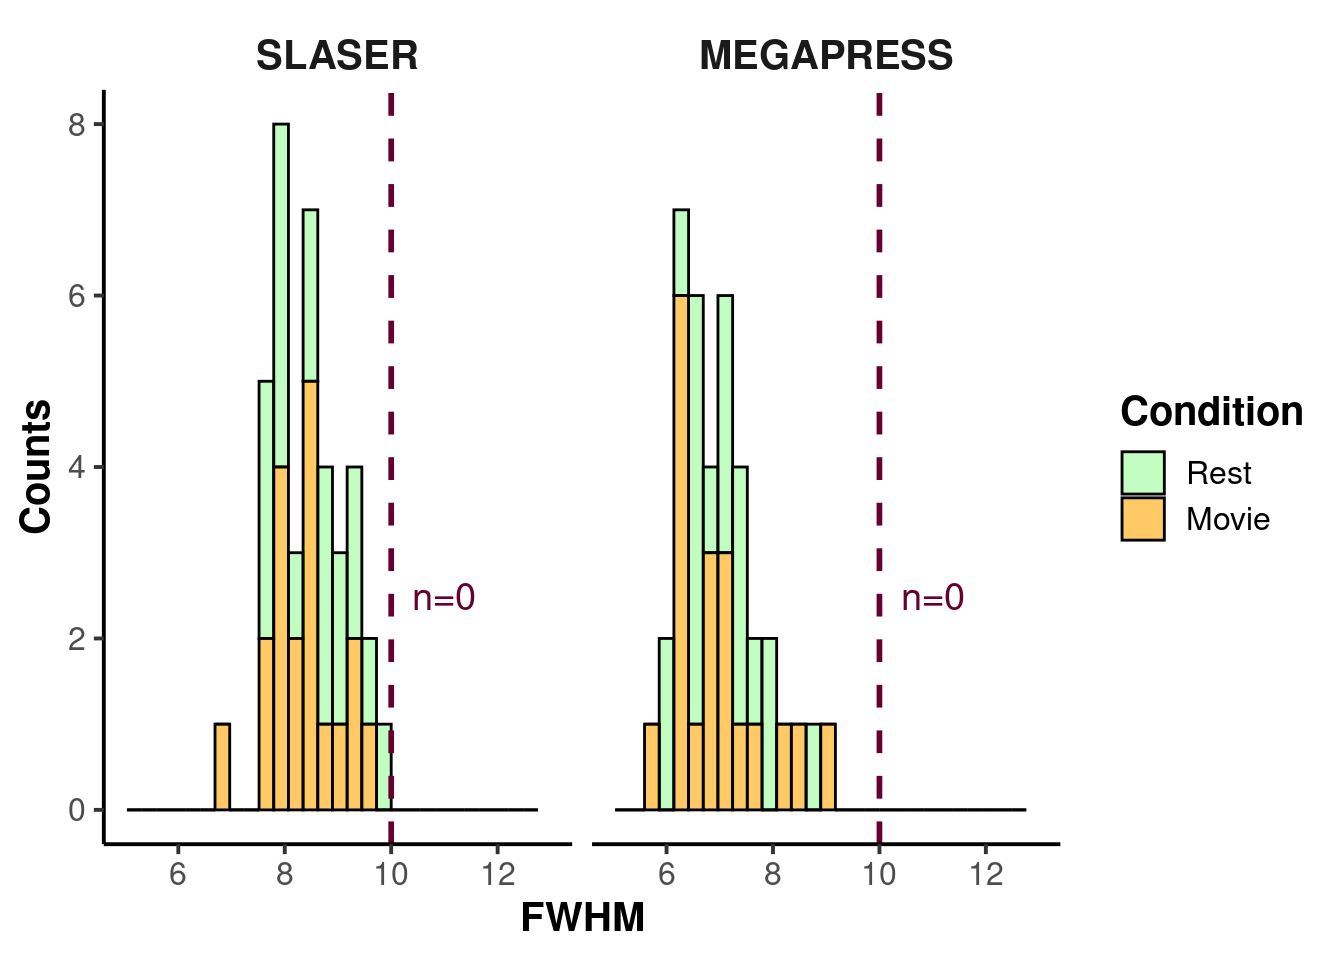

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

(`geom_bar()`).

png 
  2 

In [ ]:
(fwhm_plot <- ggplot(fwhm_df, aes(x = FWHM, group = Condition, fill = Condition)) +
  geom_histogram(position = "stack", alpha = 0.6, color = "black", boundary = 10) +
  facet_wrap(~ factor(Method, levels = c("SLASER", "MEGAPRESS"))) +
  theme_classic(base_size = 15) +
  scale_fill_manual(values = c("#98FB98", "#FFA500")) +
  theme(
    strip.background = element_blank(), strip.text.x = element_text(size = 15, face = "bold"),
    axis.title = element_text(face = "bold"), legend.title = element_text(face = "bold")
  ) +
  geom_vline(aes(xintercept = 10), linewidth = 1, color = "#660033", linetype = 2) +
  geom_text(data = fwhm_annot, mapping = aes(x = 11, y = 2.5, label = Annotation), color = "#660033", size = 5, inherit.aes = F) +
  ylab("Counts") +
  xlim(5, 13))

Who are the subjects, and under which condition, do we have FWHM \> 10?

In [ ]:
fwhm_df <- dplyr::select(df, grep("FWHM", names(df)))
fwhm_df <- fwhm_df %>% rename(Rest_FWHM_MEGAPRESS = Rest_FWHM_Osprey, Movie_FWHM_MEGAPRESS = Movie_FWHM_Osprey)
fwhm_df$SubjectID <- subjects$SubjectID
fwhm_df <- reshape2::melt(fwhm_df)

Using SubjectID as id variables

  Subject     FWHM Condition   Method
  --------- ------ ----------- --------


Now let’s take a look at quality for our fMRI data. Mean framewise displacement (mean FD) is an estimate of a participant’s movement over time. In general, we want to see mean FD lower than 0.15.

Summary statistics:

In [ ]:
meanfd <- dplyr::select(df, Rest_MeanFD, Movie_MeanFD)
meanfd <- reshape2::melt(meanfd)

No id variables; using all as measure variables

In [ ]:
knitr::kable(meanfd %>% group_by(Condition) %>% summarise(mean = round(mean(MeanFD), 2), sd = round(sd(MeanFD), 2)))

  Condition     mean     sd
  ----------- ------ ------
  Rest          0.10   0.03
  Movie         0.11   0.02


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

(`geom_bar()`).

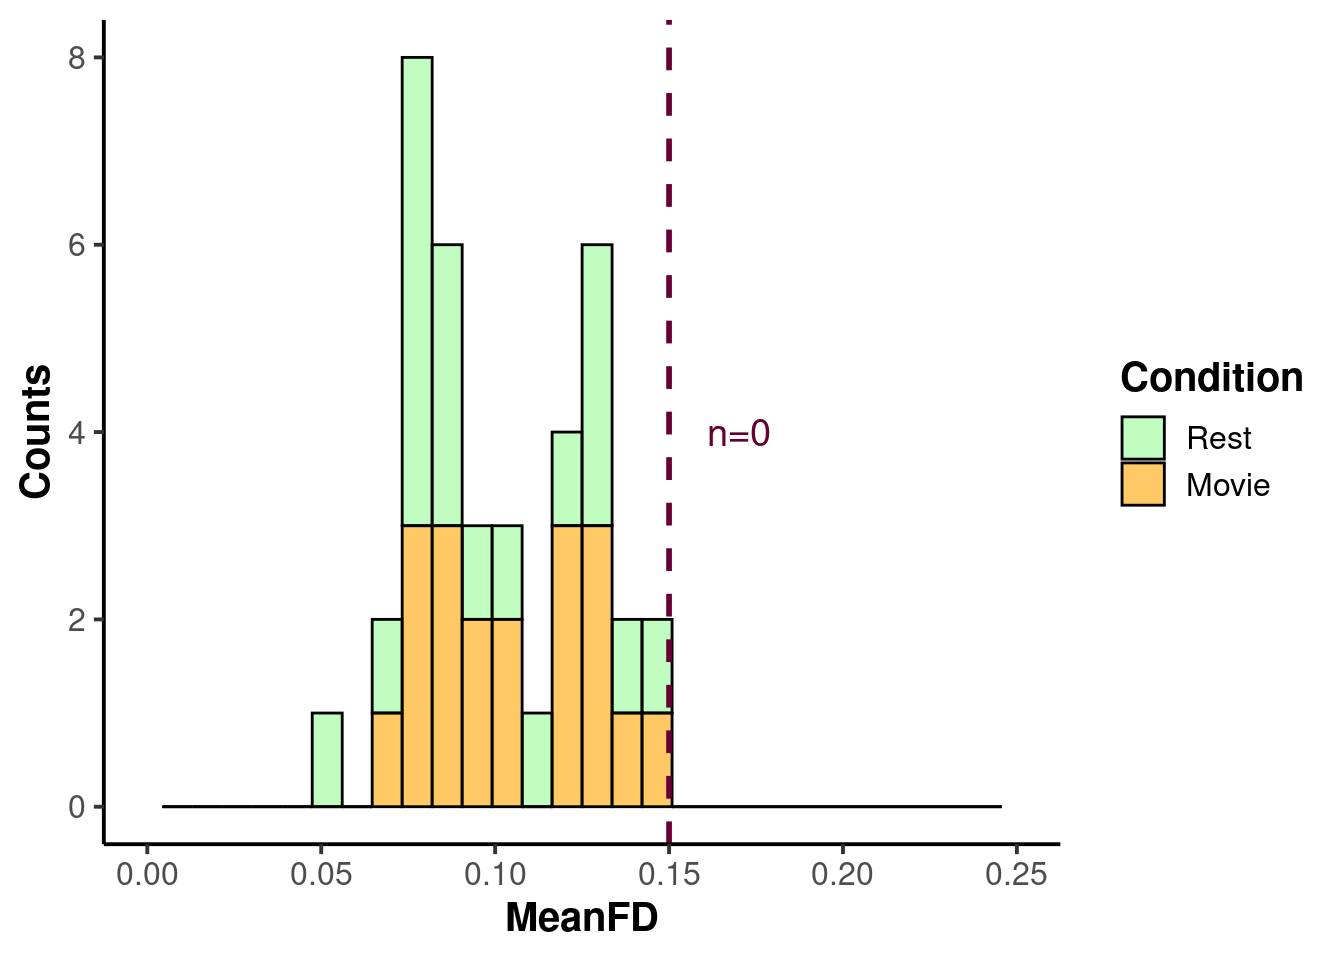

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

(`geom_bar()`).

png 
  2 

In [ ]:
(meanfd_plot <- ggplot(meanfd, aes(x = MeanFD, group = Condition, fill = Condition)) +
  geom_histogram(position = "stack", alpha = 0.6, color = "black", center = 10) +
  theme_classic(base_size = 15) +
  scale_fill_manual(values = c("#98FB98", "#FFA500")) +
  theme(axis.title = element_text(face = "bold"), legend.title = element_text(face = "bold")) +
  geom_vline(aes(xintercept = 0.15), linewidth = 1, color = "#660033", linetype = 2) +
  geom_text(data = meanfd_annot, mapping = aes(x = 0.17, y = 4, label = Annotation), color = "#660033", size = 5, inherit.aes = F) +
  ylab("Counts") +
  xlim(0, 0.25))

Who are the subjects, and under what conditions, do we see meanFD \> 0.15?

In [ ]:
meanfd2 <- dplyr::select(df, Rest_MeanFD, Movie_MeanFD)
meanfd2$SubjectID <- subjects$SubjectID
meanfd2 <- reshape2::melt(meanfd2)

Using SubjectID as id variables

  Subject     meanFD Condition
  --------- -------- -----------


In [ ]:
# Let's create a handy vector containing Hurst values and another containing glutamate values.
glu <- dplyr::select(df, Rest_Glu, Movie_Glu)
glu <- reshape2::melt(glu)

No id variables; using all as measure variables

No id variables; using all as measure variables

Is meanFD correlated with Hurst?

In [ ]:
meanfd_rest <- dplyr::filter(meanfd, Condition == "Rest")
meanfd_movie <- dplyr::filter(meanfd, Condition == "Movie")
meanfd_rest.model <- cor.test(meanfd_rest$MeanFD, df$Rest_Hurst)
print(meanfd_rest.model)


    Pearson's product-moment correlation

data:  meanfd_rest$MeanFD and df$Rest_Hurst
t = -1.4582, df = 17, p-value = 0.163
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6840465  0.1423292
sample estimates:
       cor 
-0.3334358 


    Pearson's product-moment correlation

data:  meanfd_movie$MeanFD and df$Movie_Hurst
t = -2.387, df = 17, p-value = 0.02888
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.77814823 -0.06060282
sample estimates:
       cor 
-0.5010208 


    Welch Two Sample t-test

data:  meanfd_rest$MeanFD and meanfd_movie$MeanFD
t = -0.69523, df = 35.692, p-value = 0.4914
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.02244491  0.01098769
sample estimates:
 mean of x  mean of y 
0.09948482 0.10521344 


Call:
lm(formula = Hurst ~ MeanFD, data = fd_hurst)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.24149 -0.08640 -0.01106  0.07934  0.25309 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.17046    0.07314  16.004   <2e-16 ***
MeanFD      -1.53171    0.69435  -2.206   0.0339 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1065 on 36 degrees of freedom
Multiple R-squared:  0.1191,    Adjusted R-squared:  0.09461 
F-statistic: 4.866 on 1 and 36 DF,  p-value: 0.03386

`geom_smooth()` using formula = 'y ~ x'

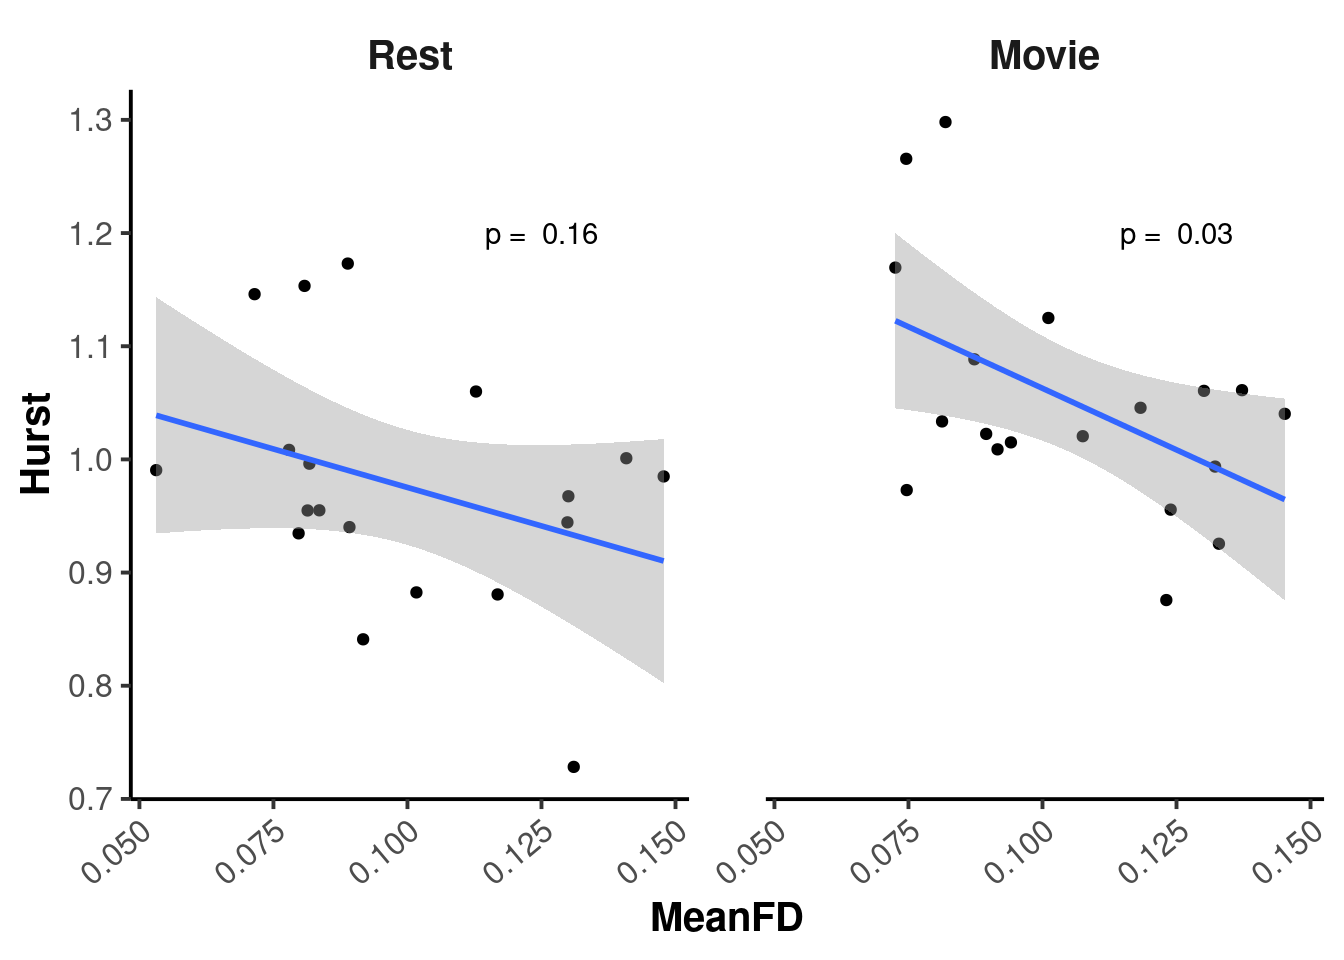

`geom_smooth()` using formula = 'y ~ x'

png 
  2 

In [ ]:
# pearson_fd_hurst <- cor.test(fd_hurst$MeanFD, fd_hurst$Hurst, method="pearson")
meanfd$Hurst <- fd_hurst$Hurst

dat_text <- data.frame(
  label = c(paste("p = ", round(meanfd_rest.model$p.value, 2)), paste("p = ", round(meanfd_movie.model$p.value, 2))),
  Condition = c("Rest", "Movie"),
  x = c(0.125, 0.125),
  y = c(1.2, 1.2)
)
(meanfd_hurst_plot <- ggplot(data = meanfd, aes(x = MeanFD, y = Hurst)) +
  geom_point() +
  geom_smooth(method = "lm") +
  theme_classic(base_size = 15) +
  theme(
    strip.background = element_blank(), strip.text.x = element_text(size = 15, face = "bold"),
    axis.title = element_text(face = "bold"), legend.title = element_text(face = "bold")
  ) +
  facet_wrap(~ factor(Condition, levels = c("Rest", "Movie"))) +
  geom_text(
    data = dat_text,
    mapping = aes(x = x, y = y, label = label)
  ) +
  scale_x_continuous(guide = guide_axis(angle = 40)) +
  theme(panel.spacing = unit(2, "lines"))
)

Is Glutamate or GABA correlated with FWHM?

In [ ]:
(glufwhm_cor <- cor.test(df$Rest_Glx, df$Rest_FWHM_SLASER))


    Pearson's product-moment correlation

data:  df$Rest_Glx and df$Rest_FWHM_SLASER
t = -2.602, df = 17, p-value = 0.0186
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.7951469 -0.1049050
sample estimates:
       cor 
-0.5336848 


    Pearson's product-moment correlation

data:  df$Movie_Glx and df$Movie_FWHM_SLASER
t = -1.249, df = 17, p-value = 0.2286
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6575385  0.1892094
sample estimates:
       cor 
-0.2899154 


    Pearson's product-moment correlation

data:  df$Rest_GABAplus and df$Rest_FWHM_Osprey
t = -1.5552, df = 17, p-value = 0.1383
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6956232  0.1206223
sample estimates:
       cor 
-0.3529229 


    Pearson's product-moment correlation

data:  df$Movie_GABAplus and df$Movie_FWHM_Osprey
t = -0.13104, df = 17, p-value = 0.8973
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4790635  0.4286273
sample estimates:
        cor 
-0.03176647 

It appears Glutamate values are negatively correlated with their FWHM…

`geom_smooth()` using formula = 'y ~ x'

Warning in is.na(x): is.na() applied to non-(list or vector) of type
'expression'

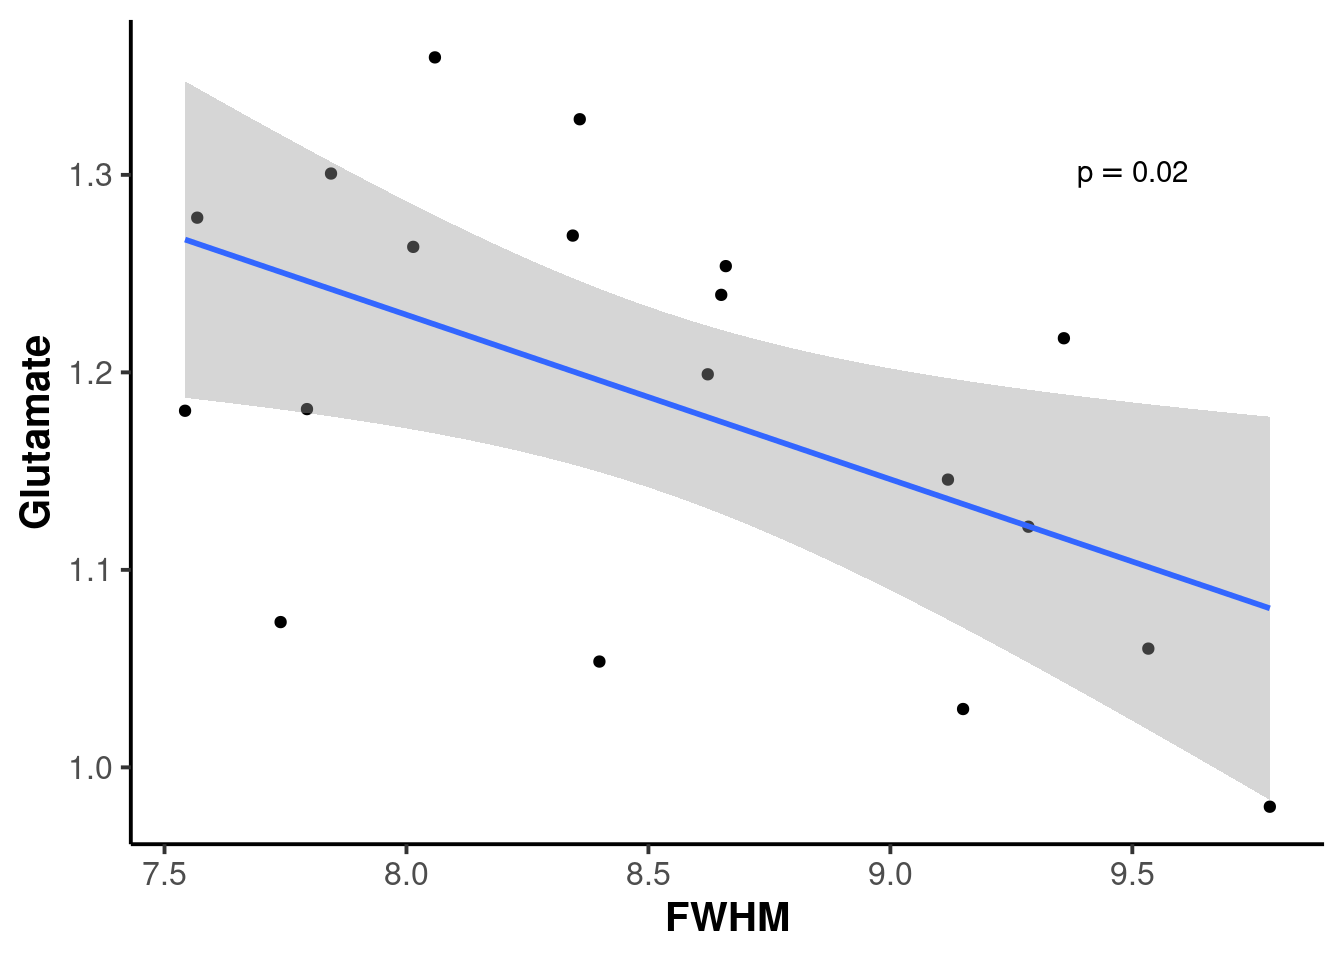

`geom_smooth()` using formula = 'y ~ x'

Warning in is.na(x): is.na() applied to non-(list or vector) of type
'expression'

png 
  2 

In [ ]:
(glu_FWHM_plot <- ggplot(data = df, aes(x = Rest_FWHM_SLASER, y = Rest_Glx)) +
  geom_point() +
  geom_smooth(method = "lm") +
  theme_classic(base_size = 15) +
  theme(axis.title = element_text(face = "bold")) +
  ylab("Glutamate") +
  xlab("FWHM") +
  annotate(geom = "text", x = 9.5, y = 1.3, label = parse(text = paste(
    "p == ",
    round(glufwhm_cor$p.value, 2)
  )))
)

If we remove the two subjects with FWHM \> 10, what happens?

In [ ]:
(glufwhm_nooutliers_cor <- df %>% filter(!Rest_FWHM_SLASER > 10) %>% with(cor.test(Rest_Glx, Rest_FWHM_SLASER)))


    Pearson's product-moment correlation

data:  Rest_Glx and Rest_FWHM_SLASER
t = -2.602, df = 17, p-value = 0.0186
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.7951469 -0.1049050
sample estimates:
       cor 
-0.5336848 

`geom_smooth()` using formula = 'y ~ x'

Warning in is.na(x): is.na() applied to non-(list or vector) of type
'expression'

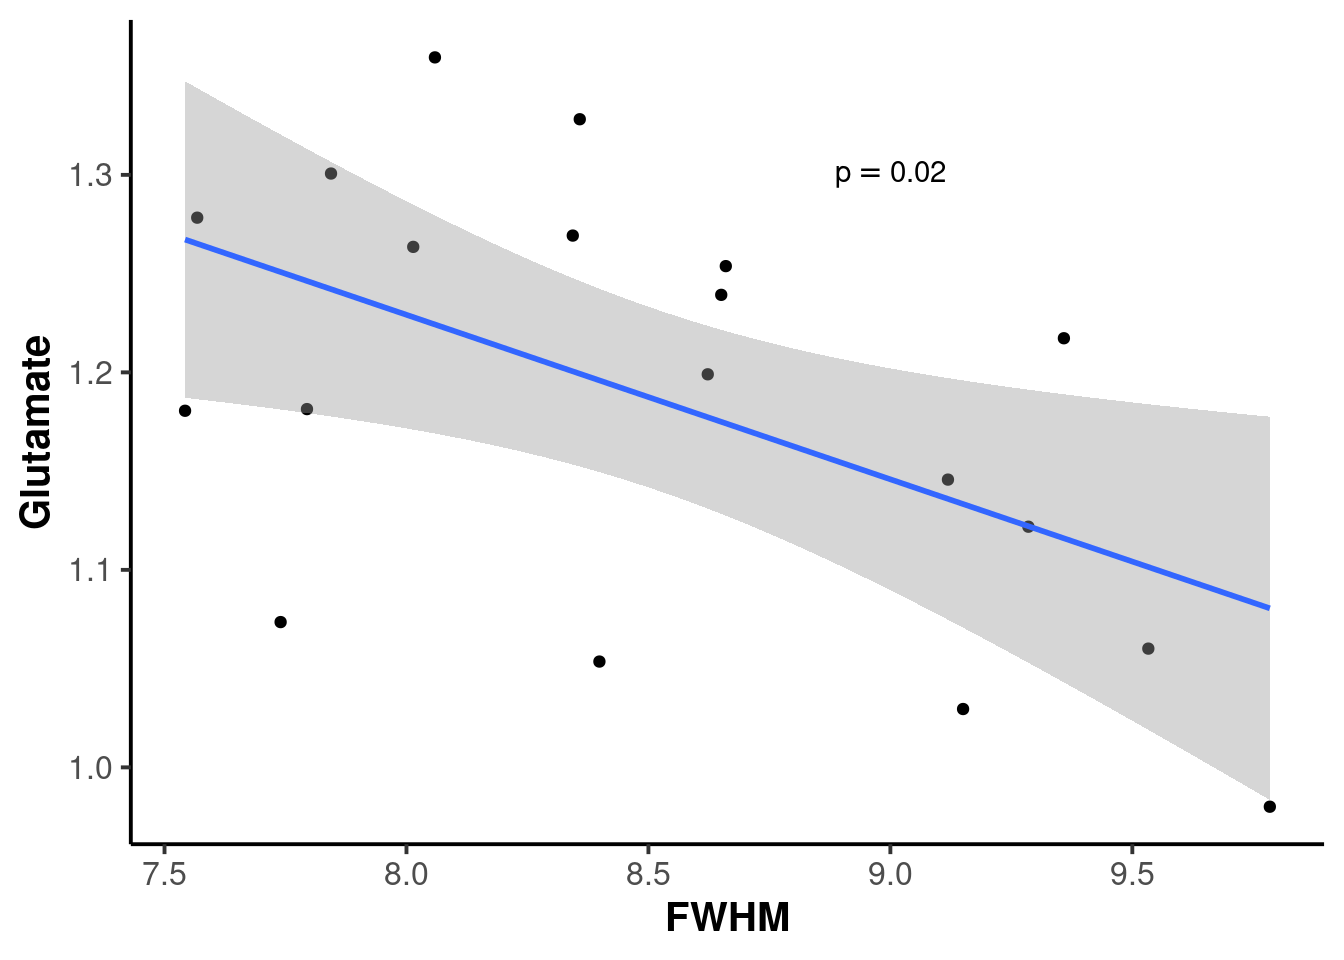

In [ ]:
glu_FWHM_nooutliers_plot <- df %>%
  filter(!Rest_FWHM_SLASER > 10) %>%
  ggplot(aes(x = Rest_FWHM_SLASER, y = Rest_Glx)) +
  geom_point() +
  geom_smooth(method = "lm") +
  theme_classic(base_size = 15) +
  theme(axis.title = element_text(face = "bold")) +
  ylab("Glutamate") +
  xlab("FWHM") +
  annotate(geom = "text", x = 9, y = 1.3, label = parse(text = paste(
    "p == ",
    round(glufwhm_nooutliers_cor$p.value, 2)
  )))
print(glu_FWHM_nooutliers_plot)

It seems to go away. We may want to remove these two subjects, or control for FWHM in our modelling.

Are FWHM different between MEGAPRESS and sLASER?

In [ ]:
t.test(df$Rest_FWHM_SLASER, df$Rest_FWHM_Osprey)


    Welch Two Sample t-test

data:  df$Rest_FWHM_SLASER and df$Rest_FWHM_Osprey
t = 6.5977, df = 35.996, p-value = 1.114e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.036627 1.956797
sample estimates:
mean of x mean of y 
 8.517111  7.020399 


    Welch Two Sample t-test

data:  df$Movie_FWHM_SLASER and df$Movie_FWHM_Osprey
t = 5.6114, df = 33.559, p-value = 2.874e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.8851927 1.8911858
sample estimates:
mean of x mean of y 
 8.367188  6.978999 

# Results

Let’s move on to results! How does Hurst change with condition?

In [ ]:
hurst_df <- dplyr::select(df, Subject, Rest_Hurst, Movie_Hurst)
hurst_effect_size <- cohensD(hurst_df$Rest_Hurst, hurst_df$Movie_Hurst)
(ttest_hurst <- t.test(hurst_df$Rest_Hurst, hurst_df$Movie_Hurst, paired = TRUE))


    Paired t-test

data:  hurst_df$Rest_Hurst and hurst_df$Movie_Hurst
t = -3.8616, df = 18, p-value = 0.001143
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -0.11666745 -0.03445087
sample estimates:
mean difference 
    -0.07555916 


    Welch Two Sample t-test

data:  hurst_m$Hurst and hurst_f$Hurst
t = 0.8975, df = 24.523, p-value = 0.3782
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.04380539  0.11135273
sample estimates:
mean of x mean of y 
 1.031471  0.997697 


    Pearson's product-moment correlation

data:  hurst_df$Hurst and hurst_df$Age
t = -1.3789, df = 36, p-value = 0.1764
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5073346  0.1030873
sample estimates:
       cor 
-0.2239773 


    Welch Two Sample t-test

data:  deltaH_m$deltaH and deltaH_f$deltaH
t = 1.3237, df = 15.34, p-value = 0.205
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0311998  0.1339795
sample estimates:
mean of x mean of y 
0.1026064 0.0512166 


    Pearson's product-moment correlation

data:  deltaH_df$deltaH and deltaH_df$Age
t = 1.1183, df = 17, p-value = 0.279
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2184139  0.6398927
sample estimates:
      cor 
0.2617638 

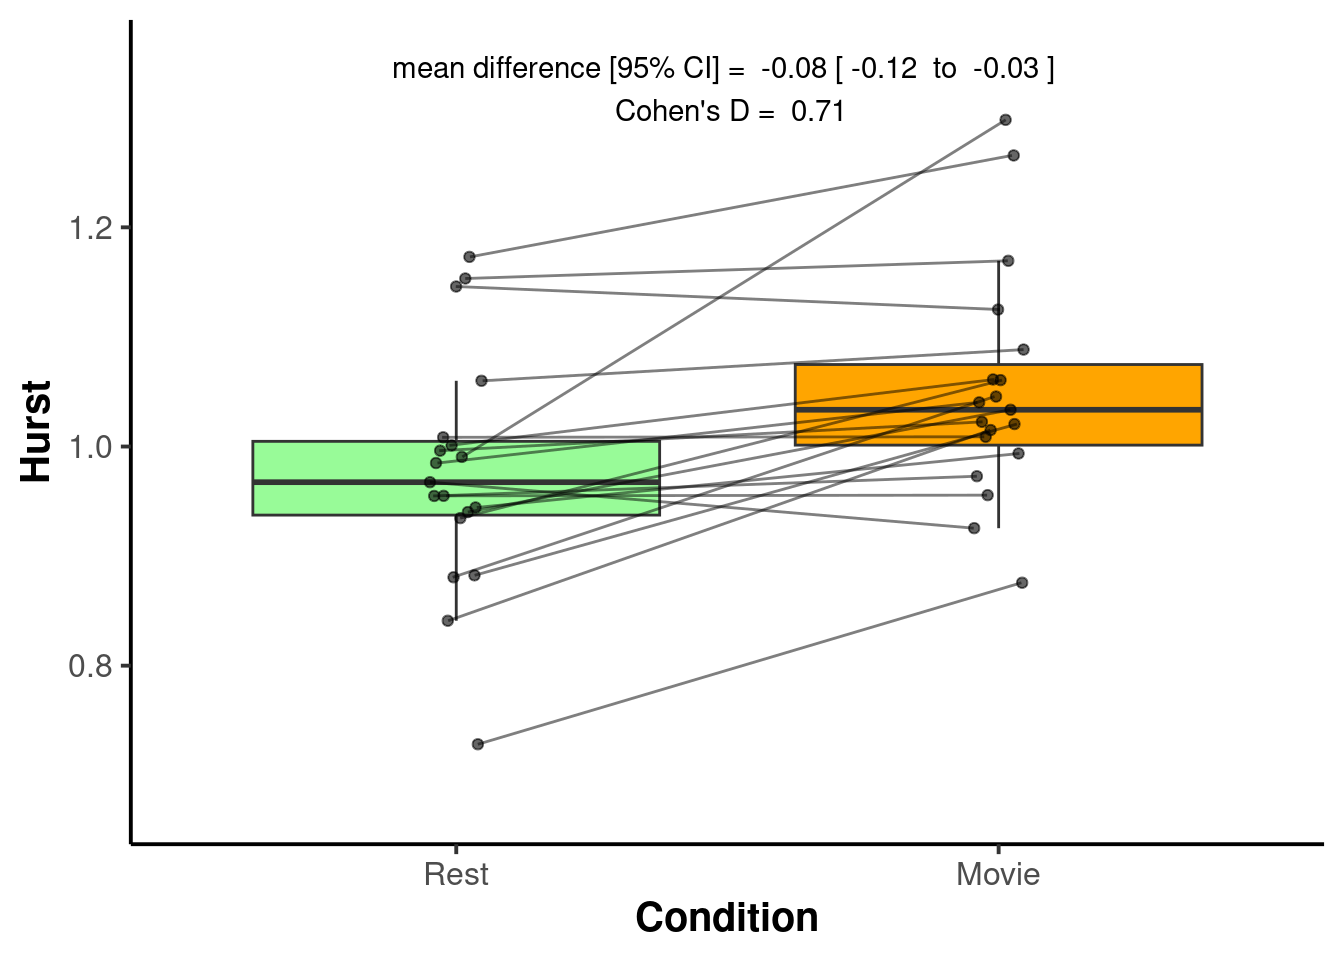

png 
  2 

In [ ]:
minmax <- c(min(hurst_df$Hurst), max(hurst_df$Hurst))
space <- (minmax[2] - minmax[1]) / 10
(hurst_boxplot <- ggplot(hurst_df, aes(x = Condition, y = Hurst, fill = Condition)) +
  geom_boxplot(outlier.shape = NA) +
  geom_point(alpha = 0.6, position = position_jitterdodge(dodge.width = 0.1, jitter.width = 0.01, seed = 123), aes(group = Sub)) +
  geom_line(aes(group = Sub), position = position_jitterdodge(dodge.width = 0.1, jitter.width = 0.01, seed = 123), alpha = 0.5) +
  scale_fill_manual(values = c("#98FB98", "#FFA500"), guide = "none") +
  theme_classic(base_size = 15) +
  ylim(minmax[1] - space, minmax[2] + space) +
  theme(axis.title = element_text(face = "bold"), legend.position = "none") +
  annotate(geom = "text", x = 1.5, y = minmax[2] + space / 2, label = paste(
    # roundedpvalue,
    "mean difference [95% CI] = ",
    round(as.numeric(ttest_hurst$estimate), 2),
    "[",
    round(as.numeric(ttest_hurst$conf.int)[1], 2),
    " to ",
    round(as.numeric(ttest_hurst$conf.int)[2], 2),
    "]",
    "\n Cohen's D = ",
    round(hurst_effect_size, 2)
  ))
)

How does glutamate change with condition?

In [ ]:
glu_df <- dplyr::select(df, Subject, Rest_Glx, Movie_Glx)
glu_effect_size <- cohensD(glu_df$Rest_Glx, glu_df$Movie_Glx)
(ttest_glu <- t.test(glu_df$Rest_Glx, glu_df$Movie_Glx, paired = TRUE))


    Paired t-test

data:  glu_df$Rest_Glx and glu_df$Movie_Glx
t = 1.7827, df = 18, p-value = 0.09151
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -0.008683338  0.105974259
sample estimates:
mean difference 
     0.04864546 


    Welch Two Sample t-test

data:  glu_m$Glx and glu_f$Glx
t = -1.1613, df = 34.963, p-value = 0.2534
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.11233177  0.03058408
sample estimates:
mean of x mean of y 
 1.140228  1.181102 


    Pearson's product-moment correlation

data:  glu_df$Glx and glu_df$Age
t = -2.4327, df = 36, p-value = 0.02008
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.62085050 -0.06371267
sample estimates:
       cor 
-0.3757429 

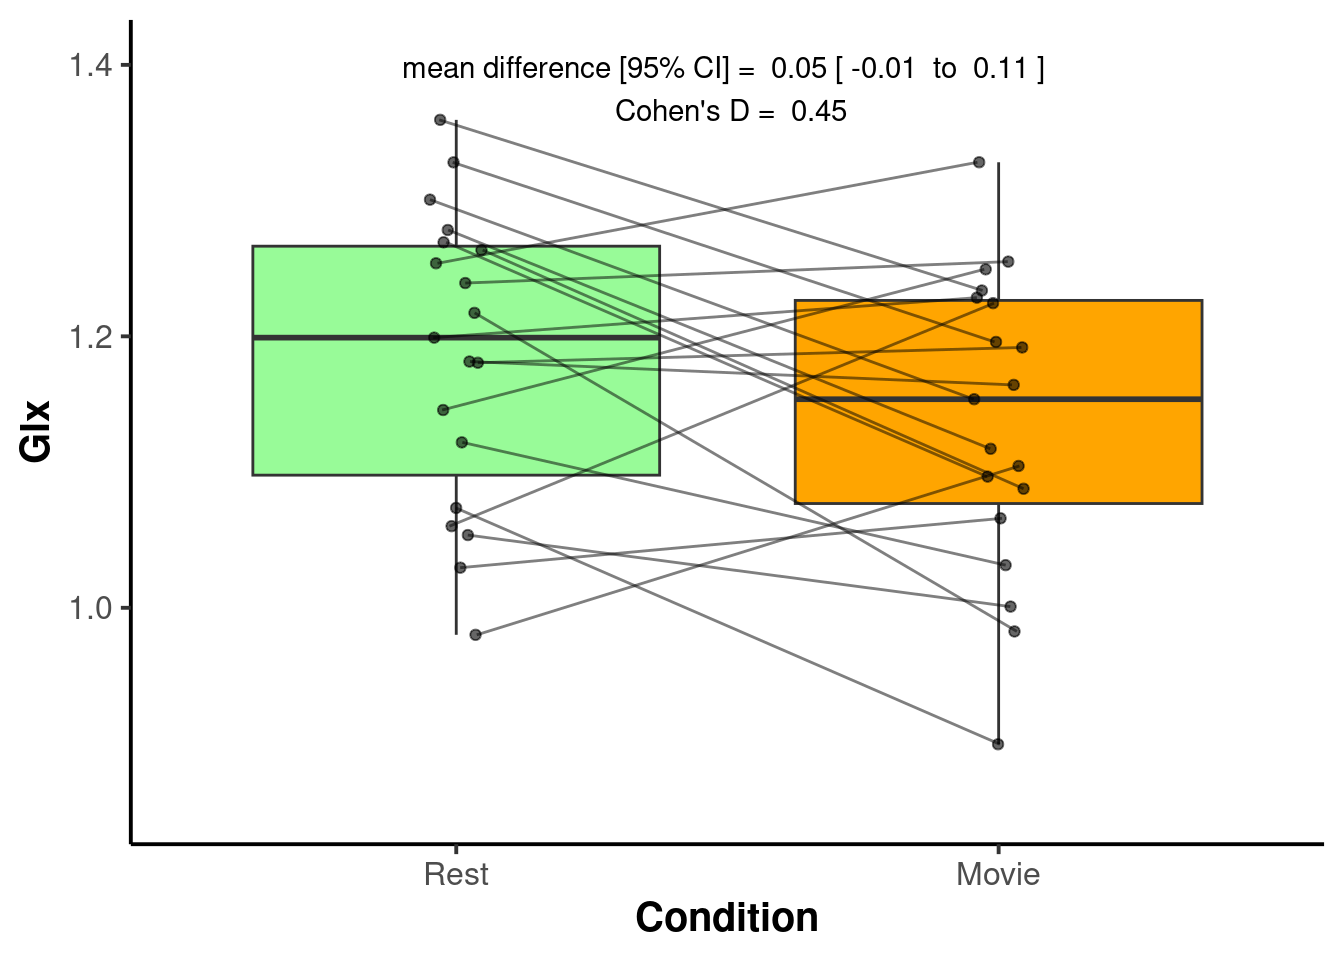

png 
  2 


    Paired t-test

data:  df$Rest_Glx and df$Movie_Glx
t = 1.7827, df = 18, p-value = 0.09151
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -0.008683338  0.105974259
sample estimates:
mean difference 
     0.04864546 

In [ ]:
minmax <- c(min(glu_df$Glx), max(glu_df$Glx))
space <- (minmax[2] - minmax[1]) / 10
(glu_boxplot <- ggplot(glu_df, aes(x = Condition, y = Glx, fill = Condition)) +
  scale_fill_manual(values = c("#98FB98", "#FFA500"), guide = "none") +
  theme_classic(base_size = 15) +
  theme(axis.title = element_text(face = "bold"), legend.position = "none") +
  geom_boxplot(outlier.shape = NA) +
  geom_point(alpha = 0.6, position = position_jitterdodge(dodge.width = 0.1, jitter.width = 0.01, seed = 123), aes(group = Sub)) +
  geom_line(aes(group = Sub), position = position_jitterdodge(dodge.width = 0.1, jitter.width = 0.01, seed = 123), alpha = 0.5) +
  ylim(minmax[1] - space, minmax[2] + space) +
  annotate(geom = "text", x = 1.5, y = minmax[2] + space / 2, label = paste(
    "mean difference [95% CI] = ",
    round(as.numeric(ttest_glu$estimate), 2),
    "[",
    round(as.numeric(ttest_glu$conf.int)[1], 2),
    " to ",
    round(as.numeric(ttest_glu$conf.int)[2], 2),
    "]",
    "\n Cohen's D = ",
    round(glu_effect_size, 2)
  ))
)

How does GABA change with condition?

In [ ]:
gaba_df <- dplyr::select(df, Subject, Rest_GABAplus, Movie_GABAplus)
gaba_effect_size <- cohensD(gaba_df$Rest_GABAplus, gaba_df$Movie_GABAplus)
(ttest_gaba <- t.test(gaba_df$Rest_GABAplus, gaba_df$Movie_GABAplus, paired = TRUE))


    Paired t-test

data:  gaba_df$Rest_GABAplus and gaba_df$Movie_GABAplus
t = 0.68333, df = 18, p-value = 0.5031
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -0.02796285  0.05492089
sample estimates:
mean difference 
     0.01347902 


    Welch Two Sample t-test

data:  gaba_m$GABAplus and gaba_f$GABAplus
t = 0.29061, df = 35.998, p-value = 0.773
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.03601313  0.04806022
sample estimates:
mean of x mean of y 
0.4476247 0.4416011 


    Pearson's product-moment correlation

data:  gaba_df$GABAplus and gaba_df$Age
t = -0.18772, df = 36, p-value = 0.8521
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3474812  0.2913241
sample estimates:
        cor 
-0.03127165 

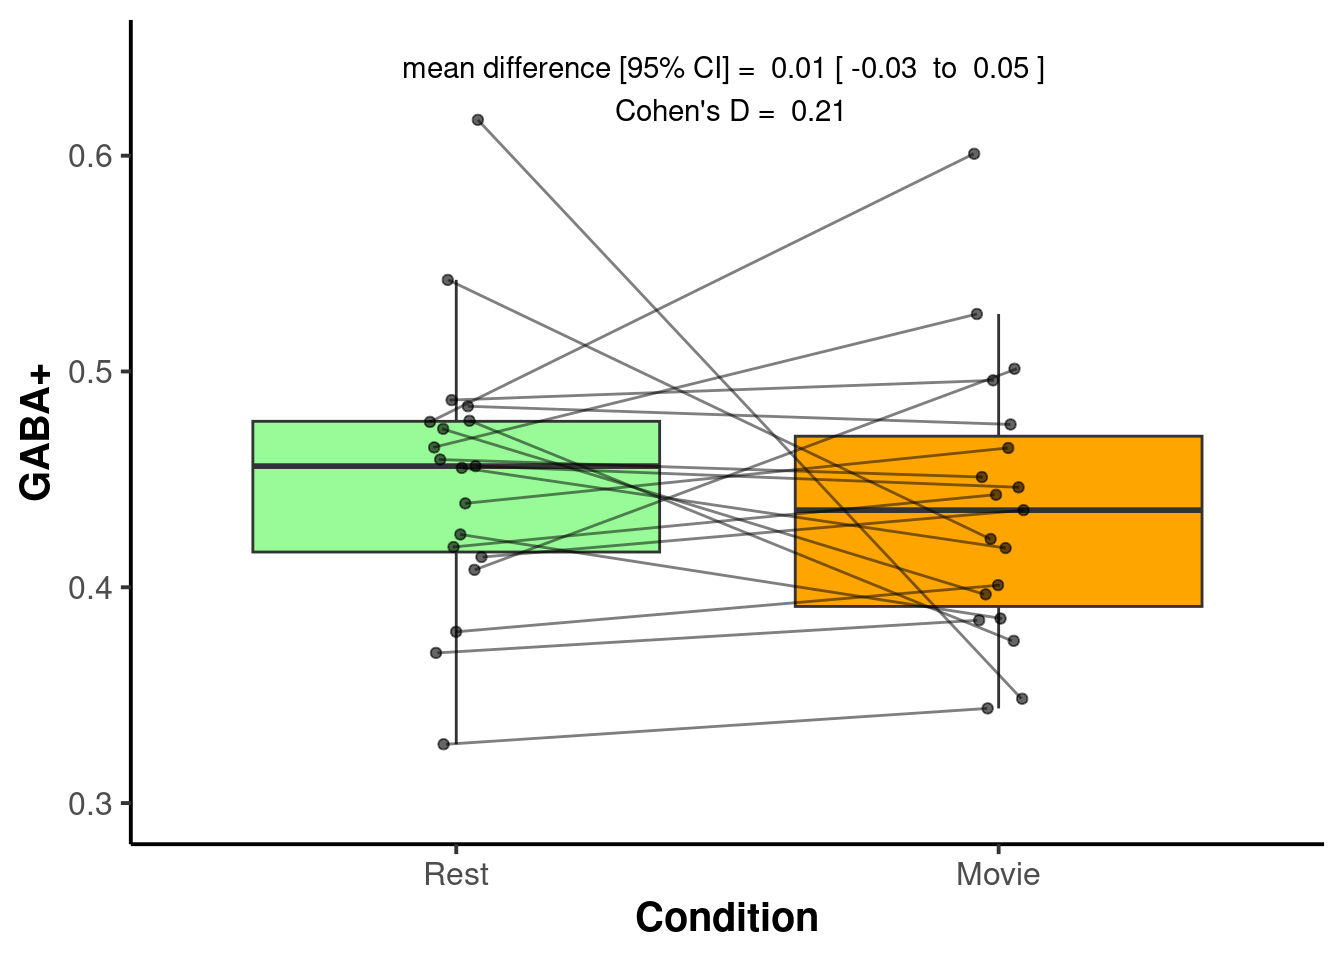

png 
  2 

In [ ]:
minmax <- c(min(gaba_df$GABAplus), max(gaba_df$GABAplus))
space <- (minmax[2] - minmax[1]) / 10
(gaba_boxplot <- ggplot(gaba_df, aes(x = Condition, y = GABAplus, fill = Condition)) +
  scale_fill_manual(values = c("#98FB98", "#FFA500"), guide = "none") +
  theme_classic(base_size = 15) +
  ylab("GABA+") +
  theme(axis.title = element_text(face = "bold"), legend.position = "none") +
  geom_boxplot(outlier.shape = NA) +
  geom_point(alpha = 0.6, position = position_jitterdodge(dodge.width = 0.1, jitter.width = 0.01, seed = 123), aes(group = Sub)) +
  geom_line(aes(group = Sub), position = position_jitterdodge(dodge.width = 0.1, jitter.width = 0.01, seed = 123), alpha = 0.5) +
  ylim(minmax[1] - space, minmax[2] + space) +
  annotate(geom = "text", x = 1.5, y = minmax[2] + space / 2, label = paste(
    "mean difference [95% CI] = ",
    round(as.numeric(ttest_gaba$estimate), 2),
    "[",
    round(as.numeric(ttest_gaba$conf.int)[1], 2),
    " to ",
    round(as.numeric(ttest_gaba$conf.int)[2], 2),
    "]",
    "\n Cohen's D = ",
    round(gaba_effect_size, 2)
  ))
)

How does EI change with condition?

In [ ]:
ei_df <- as.data.frame(glu_df$Glx / gaba_df$GABAplus)
ei_df$Condition <- gaba_df$Condition
names(ei_df)[1] <- "EI"
rest_ei <- ei_df %>% dplyr::filter(Condition == "Rest")
rest_ei <- rest_ei[, 1]
movie_ei <- ei_df %>% dplyr::filter(Condition == "Movie")
movie_ei <- movie_ei[, 1]
ei_effect_size <- cohensD(rest_ei, movie_ei)
(ttest_ei <- t.test(rest_ei, movie_ei, paired = TRUE))


    Paired t-test

data:  rest_ei and movie_ei
t = 0.23674, df = 18, p-value = 0.8155
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -0.2619278  0.3284533
sample estimates:
mean difference 
      0.0332627 


    Welch Two Sample t-test

data:  ei_m$EI and ei_f$EI
t = -0.98887, df = 35.019, p-value = 0.3295
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.4486723  0.1547420
sample estimates:
mean of x mean of y 
 2.588194  2.735159 


    Pearson's product-moment correlation

data:  ei_df$EI and ei_df$Age
t = -0.97845, df = 36, p-value = 0.3344
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4571125  0.1673448
sample estimates:
       cor 
-0.1609489 

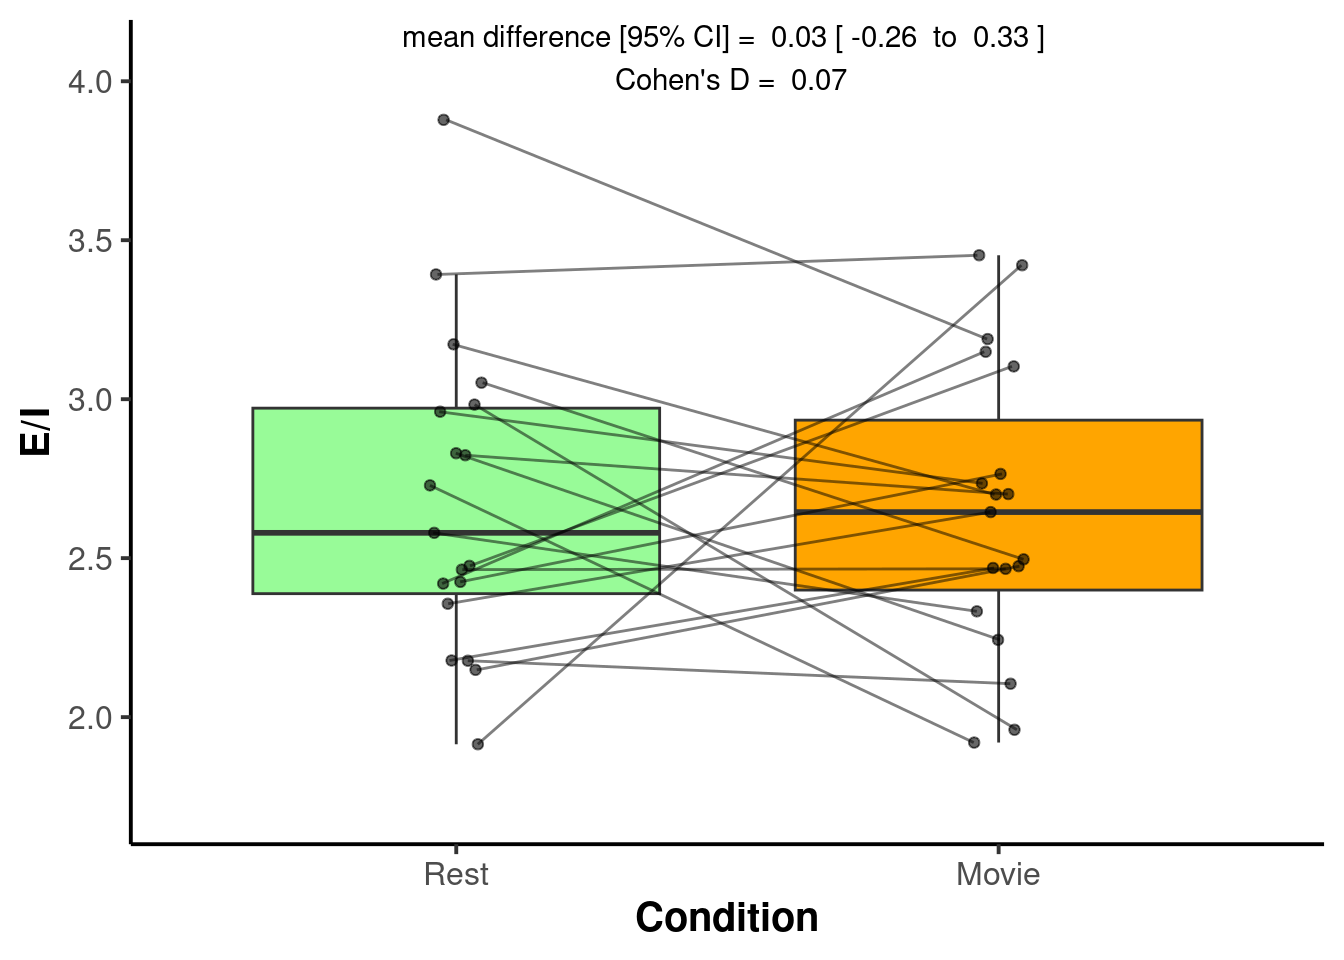

png 
  2 

In [ ]:
minmax <- c(min(ei_df$EI), max(ei_df$EI))
space <- (minmax[2] - minmax[1]) / 10
(ei_boxplot <- ggplot(ei_df, aes(x = Condition, y = EI, fill = Condition)) +
  scale_fill_manual(values = c("#98FB98", "#FFA500"), guide = "none") +
  ylab("E/I") +
  theme_classic(base_size = 15) +
  theme(axis.title = element_text(face = "bold"), legend.position = "none") +
  geom_boxplot(outlier.shape = NA) +
  geom_point(alpha = 0.6, position = position_jitterdodge(dodge.width = 0.1, jitter.width = 0.01, seed = 123), aes(group = Sub)) +
  geom_line(aes(group = Sub), position = position_jitterdodge(dodge.width = 0.1, jitter.width = 0.01, seed = 123), alpha = 0.5) +
  ylim(minmax[1] - space, minmax[2] + space) +
  annotate(geom = "text", x = 1.5, y = minmax[2] + space, label = paste(
    "mean difference [95% CI] = ",
    round(as.numeric(ttest_ei$estimate), 2),
    "[",
    round(as.numeric(ttest_ei$conf.int)[1], 2),
    " to ",
    round(as.numeric(ttest_ei$conf.int)[2], 2),
    "]",
    "\n Cohen's D = ",
    round(ei_effect_size, 2)
  ))
)

Is Hurst correlated with glutamate?

In [ ]:
glu <- dplyr::select(df, Rest_Glx, Movie_Glx)
glu_cond <- glu
glu <- reshape2::melt(glu)

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables


    Pearson's product-moment correlation

data:  gh_rest$Hurst and gh_rest$Glx
t = -0.35629, df = 17, p-value = 0.726
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5199683  0.3830981
sample estimates:
        cor 
-0.08609172 


    Pearson's product-moment correlation

data:  gh_movie$Hurst and gh_movie$Glx
t = -0.82498, df = 17, p-value = 0.4208
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5971894  0.2832526
sample estimates:
       cor 
-0.1961988 

In [ ]:
glu_hurst_model <- lm(Hurst ~ Glx, data = gh_df)
(glu_hurst_model.summary <- summary(glu_hurst_model))


Call:
lm(formula = Hurst ~ Glx, data = gh_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.28149 -0.06648 -0.01161  0.05871  0.25730 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.2552     0.1929   6.505 1.48e-07 ***
Glx          -0.2079     0.1654  -1.257    0.217    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1111 on 36 degrees of freedom
Multiple R-squared:  0.04206,   Adjusted R-squared:  0.01545 
F-statistic: 1.581 on 1 and 36 DF,  p-value: 0.2168

`geom_smooth()` using formula = 'y ~ x'

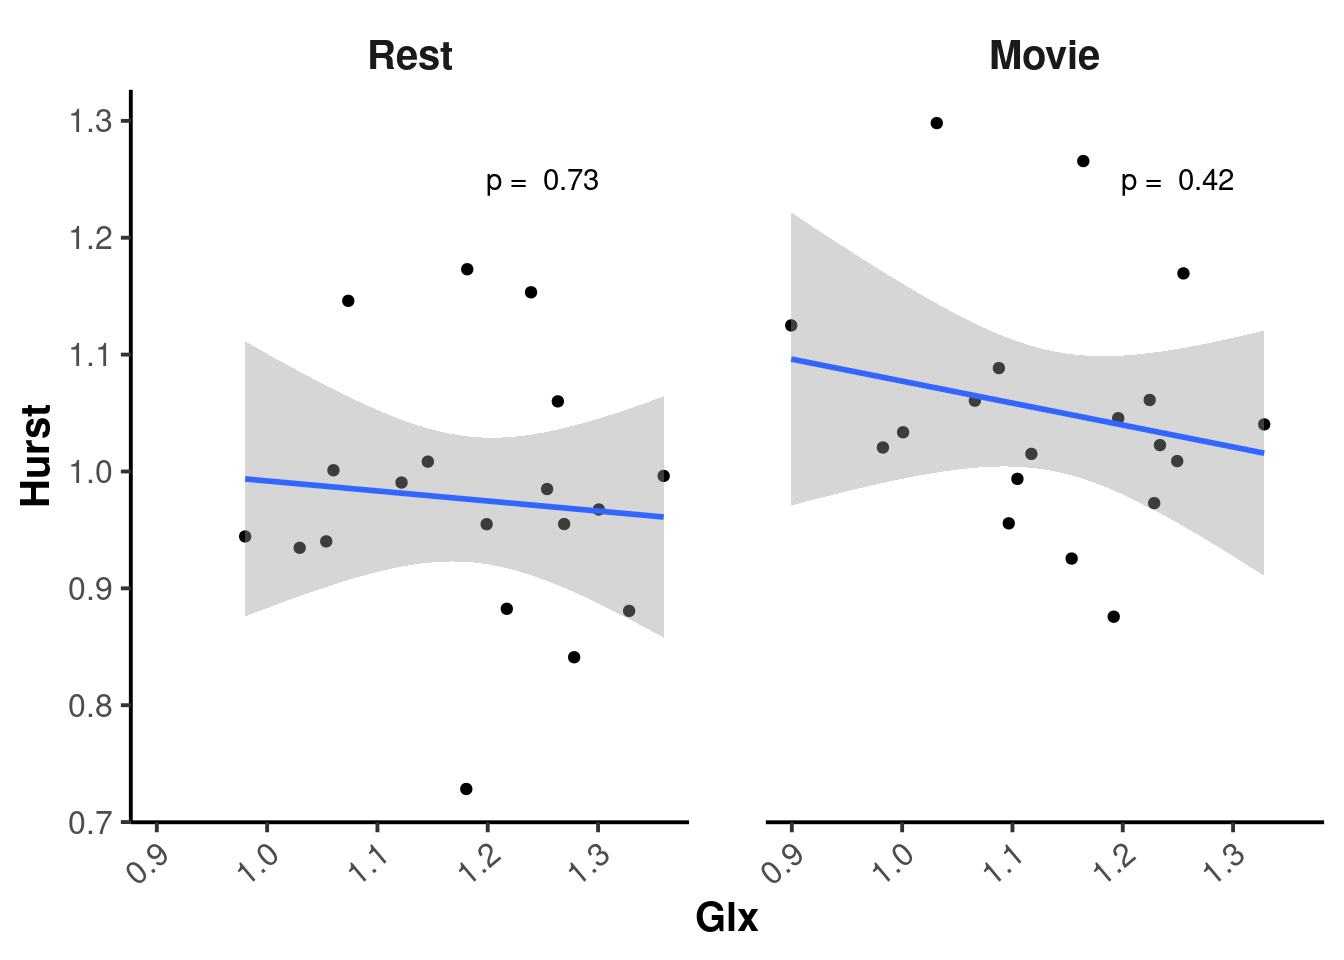

`geom_smooth()` using formula = 'y ~ x'

png 
  2 

In [ ]:
dat_text <- data.frame(
  label = c(paste("p = ", round(gh_rest_pearson$p.value, 2)), paste("p = ", round(gh_movie_pearson$p.value, 2))),
  Condition = c("Rest", "Movie"),
  x = c(1.25, 1.25),
  y = c(1.25, 1.25)
)
(glu_hurst_plot <- ggplot(data = gh_df, aes(x = Glx, y = Hurst)) +
  geom_point() +
  geom_smooth(method = "lm") +
  theme_classic(base_size = 15) +
  theme(
    strip.background = element_blank(), strip.text.x = element_text(size = 15, face = "bold"),
    axis.title = element_text(face = "bold"), legend.title = element_text(face = "bold")
  ) +
  facet_wrap(~ factor(Condition, levels = c("Rest", "Movie"))) +
  geom_text(
    data = dat_text,
    mapping = aes(x = x, y = y, label = label)
  ) +
  scale_x_continuous(guide = guide_axis(angle = 40)) +
  theme(panel.spacing = unit(2, "lines"))
)

Is Hurst correlated with GABA?

In [ ]:
gaba <- dplyr::select(df, Rest_GABAplus, Movie_GABAplus)
gaba <- reshape2::melt(gaba)

No id variables; using all as measure variables


    Pearson's product-moment correlation

data:  gabah_rest$Hurst and gabah_rest$GABAplus
t = -2.0745, df = 17, p-value = 0.05353
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.750461818  0.005970427
sample estimates:
       cor 
-0.4494577 


    Pearson's product-moment correlation

data:  gabah_movie$Hurst and gabah_movie$GABAplus
t = -0.7323, df = 17, p-value = 0.474
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5827916  0.3034382
sample estimates:
       cor 
-0.1748728 

`geom_smooth()` using formula = 'y ~ x'

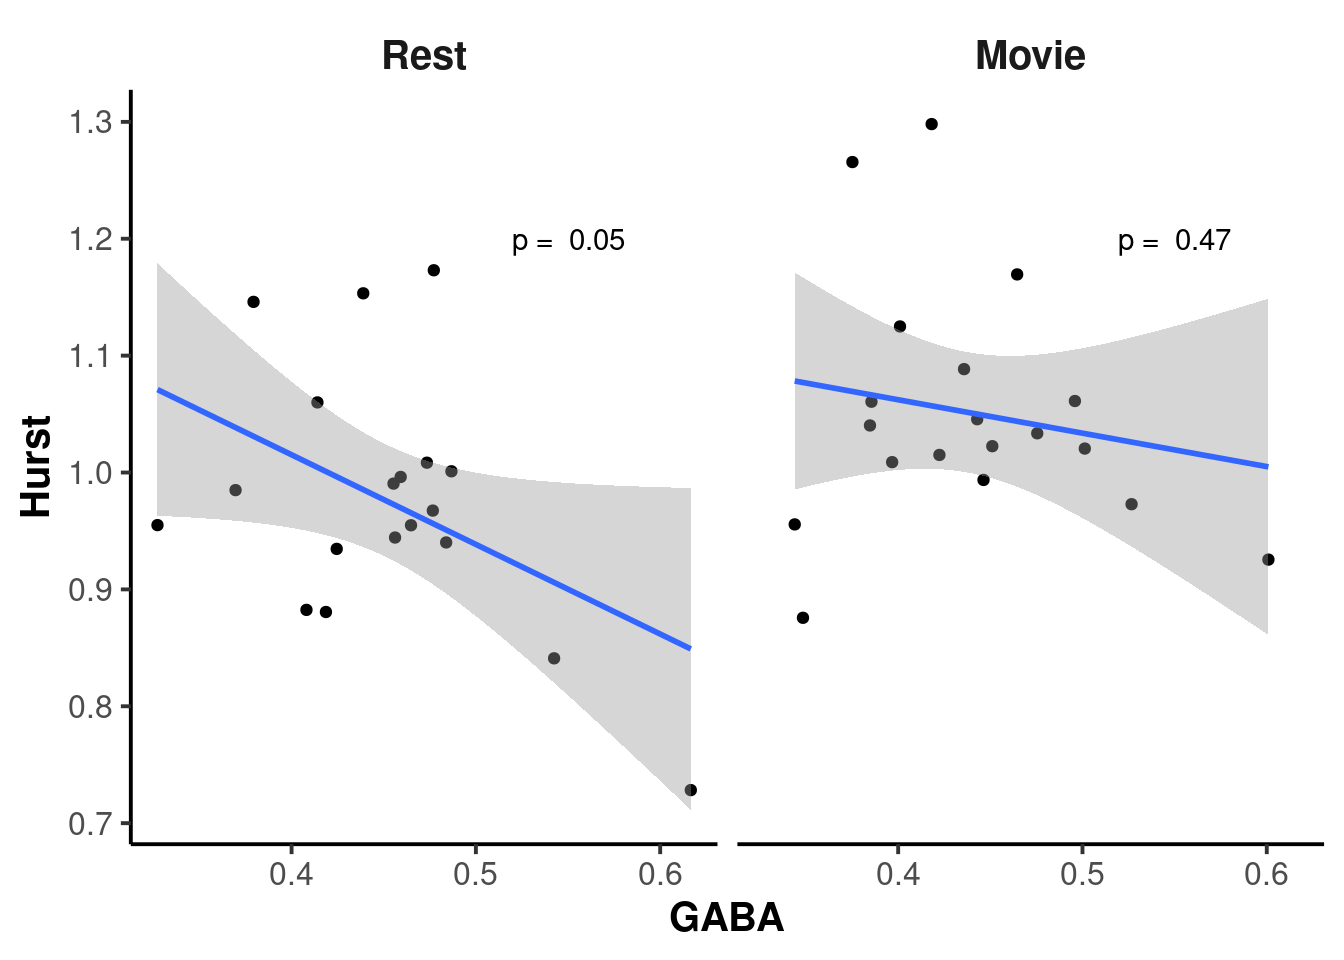

`geom_smooth()` using formula = 'y ~ x'

png 
  2 

In [ ]:
dat_text <- data.frame(
  label = c(paste("p = ", round(gabah_rest_pearson$p.value, 2)), paste("p = ", round(gabah_movie_pearson$p.value, 2))),
  Condition = c("Rest", "Movie"),
  x = c(.55, .55),
  y = c(1.2, 1.2)
)
(gaba_hurst_plot <- ggplot(data = gabah_df, aes(x = GABAplus, y = Hurst)) +
  geom_point() +
  geom_smooth(method = "lm") +
  theme_classic(base_size = 15) +
  theme(
    strip.background = element_blank(), strip.text.x = element_text(size = 15, face = "bold"),
    axis.title = element_text(face = "bold"), legend.title = element_text(face = "bold")
  ) +
  xlab("GABA") +
  ylab("Hurst") +
  facet_wrap(~ factor(Condition, levels = c("Rest", "Movie"))) +
  geom_text(
    data = dat_text,
    mapping = aes(x = x, y = y, label = label)
  )
)

Is EI correlated with Hurst?

In [ ]:
ei <- as.data.frame(glu / gaba$GABAplus)
ei$Condition <- gaba$Condition
names(ei)[1] <- "EI"
eih_df <- data.frame(hurst, ei)
names(eih_df)[1] <- "Hurst"
pearson_hurst_ei <- cor.test(eih_df$EI, eih_df$Hurst, method = "pearson")

eih_rest <- dplyr::filter(eih_df, Condition == "Rest")
eih_rest_pearson <- cor.test(eih_rest$Hurst, eih_rest$EI, method = "pearson")
print(eih_rest_pearson)


    Pearson's product-moment correlation

data:  eih_rest$Hurst and eih_rest$EI
t = 0.93641, df = 17, p-value = 0.3622
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2587679  0.6139239
sample estimates:
      cor 
0.2214721 


    Pearson's product-moment correlation

data:  eih_movie$Hurst and eih_movie$EI
t = -0.19426, df = 17, p-value = 0.8483
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4907807  0.4160402
sample estimates:
        cor 
-0.04706247 

`geom_smooth()` using formula = 'y ~ x'

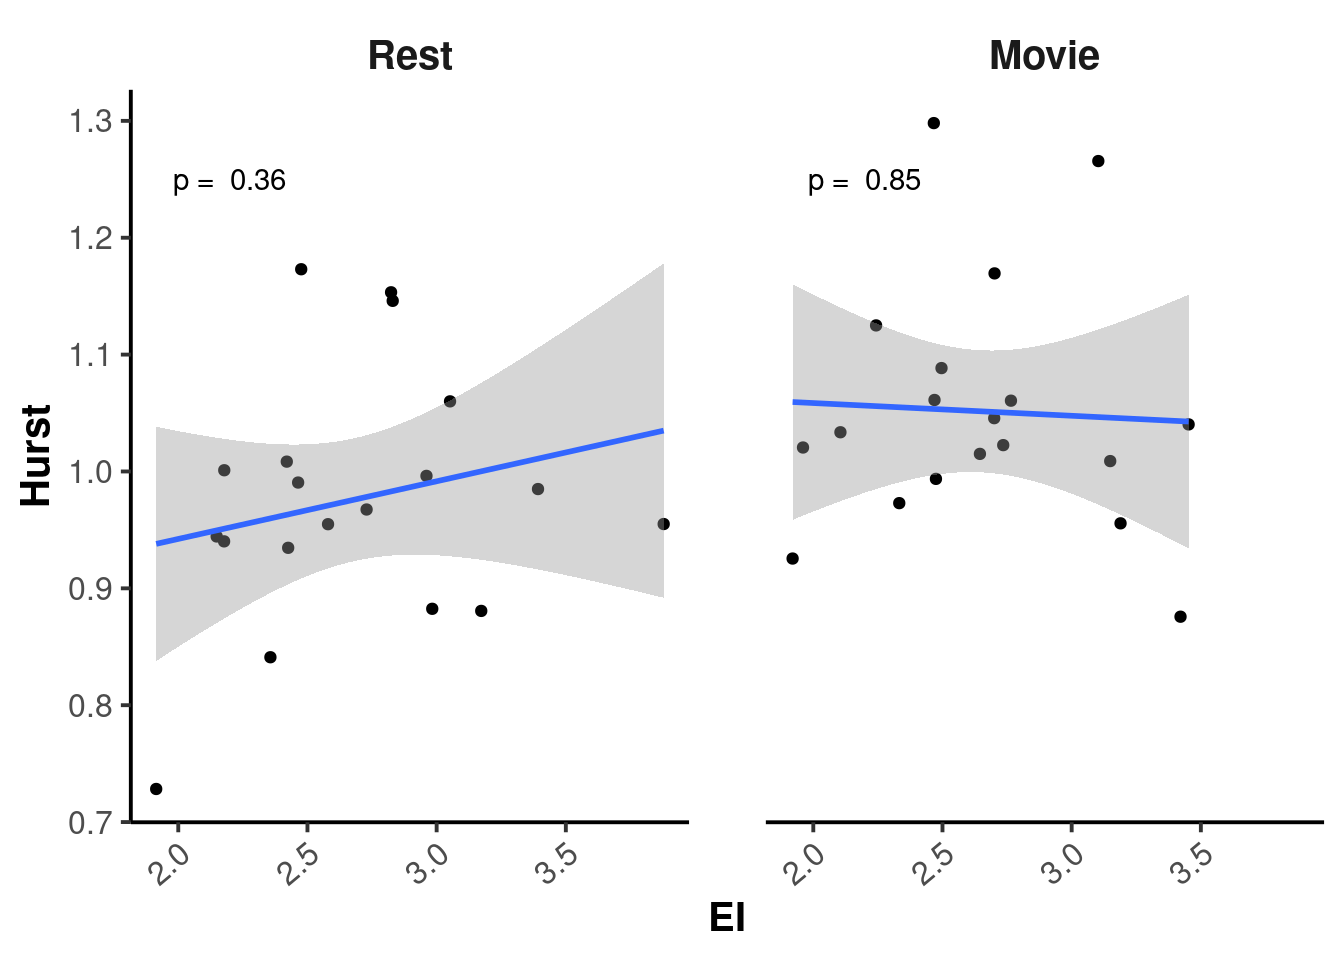

`geom_smooth()` using formula = 'y ~ x'

png 
  2 

In [ ]:
dat_text <- data.frame(
  label = c(paste("p = ", round(eih_rest_pearson$p.value, 2)), paste("p = ", round(eih_movie_pearson$p.value, 2))),
  Condition = c("Rest", "Movie"),
  x = c(2.2, 2.2),
  y = c(1.25, 1.25)
)
(ei_hurst_plot <- ggplot(data = eih_df, aes(x = EI, y = Hurst)) +
  geom_point() +
  geom_smooth(method = "lm") +
  theme_classic(base_size = 15) +
  theme(
    strip.background = element_blank(), strip.text.x = element_text(size = 15, face = "bold"),
    axis.title = element_text(face = "bold"), legend.title = element_text(face = "bold")
  ) +
  xlab("EI") +
  ylab("Hurst") +
  facet_wrap(~ factor(Condition, levels = c("Rest", "Movie"))) +
  geom_text(
    data = dat_text,
    mapping = aes(x = x, y = y, label = label)
  ) +
  scale_x_continuous(guide = guide_axis(angle = 40)) +
  theme(panel.spacing = unit(2, "lines"))
)

# Linear Mixed Effects (Welch Full Freq)

In [ ]:
df_lme <- df %>%
  select(Subject, Rest_Hurst_FullFreq, Movie_Hurst_FullFreq, Rest_Glx, Movie_Glx, Rest_GABAplus, Movie_GABAplus, Rest_FWHM_SLASER, Movie_FWHM_SLASER, Rest_FWHM_Osprey, Movie_FWHM_Osprey, Rest_MeanFD, Movie_MeanFD) %>%
  rename(Rest_Hurst = Rest_Hurst_FullFreq, Movie_Hurst = Movie_Hurst_FullFreq, Rest_FWHMsLASER = Rest_FWHM_SLASER, Movie_FWHMsLASER = Movie_FWHM_SLASER, Rest_FWHMOsprey = Rest_FWHM_Osprey, Movie_FWHMOsprey = Movie_FWHM_Osprey)
subjects_lme <- subjects %>% select(Age, Subject, Sex)
df_lme <- full_join(df_lme, subjects_lme, by = "Subject")
df_lme$Sex <- as.factor(df_lme$Sex)

In [ ]:
df_lme <- df_lme %>% pivot_longer(
  cols = -c(Age, Sex, Subject), # Exclude the Subject column from the transformation
  names_to = c("Condition", ".value"), # Split original column names
  names_pattern = "(.*)_(.*)" # Pattern to split the original column names
)
df_lme$EI <- df_lme$Glx / df_lme$GABAplus
# df_lme <- df_lme %>% select(-c(Glu,GABA))
df_lme$Condition <- as.factor(df_lme$Condition)

In [ ]:
model <- lmer(Hurst ~ EI + Age + Sex + Condition + MeanFD + (1 | Subject), data = df_lme)
#model <- lmer(Hurst ~ EI + (1 | Subject), data = df_lme)
# model <- lmer(Hurst ~ EI + Age + Sex + FWHMsLASER + FWHMOsprey + Condition + MeanFD + (1 | Subject), data = df_lme)

summary(model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Hurst ~ EI + Age + Sex + Condition + MeanFD + (1 | Subject)
   Data: df_lme

REML criterion at convergence: -50.5

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.74948 -0.48355  0.00773  0.48104  2.19218 

Random effects:
 Groups   Name        Variance Std.Dev.
 Subject  (Intercept) 0.006689 0.08179 
 Residual             0.003894 0.06240 
Number of obs: 38, groups:  Subject, 19

Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    1.115313   0.134128 29.974890   8.315 2.81e-09 ***
EI             0.029561   0.029972 24.831359   0.986  0.33351    
Age           -0.003234   0.002794 15.432299  -1.157  0.26479    
SexM           0.049897   0.047131 15.226018   1.059  0.30625    
ConditionRest -0.080272   0.020708 16.421300  -3.876  0.00128 ** 
MeanFD        -0.651067   0.744314 31.591451  -0.875  0.38833    
---
Signif. codes:  0 '*

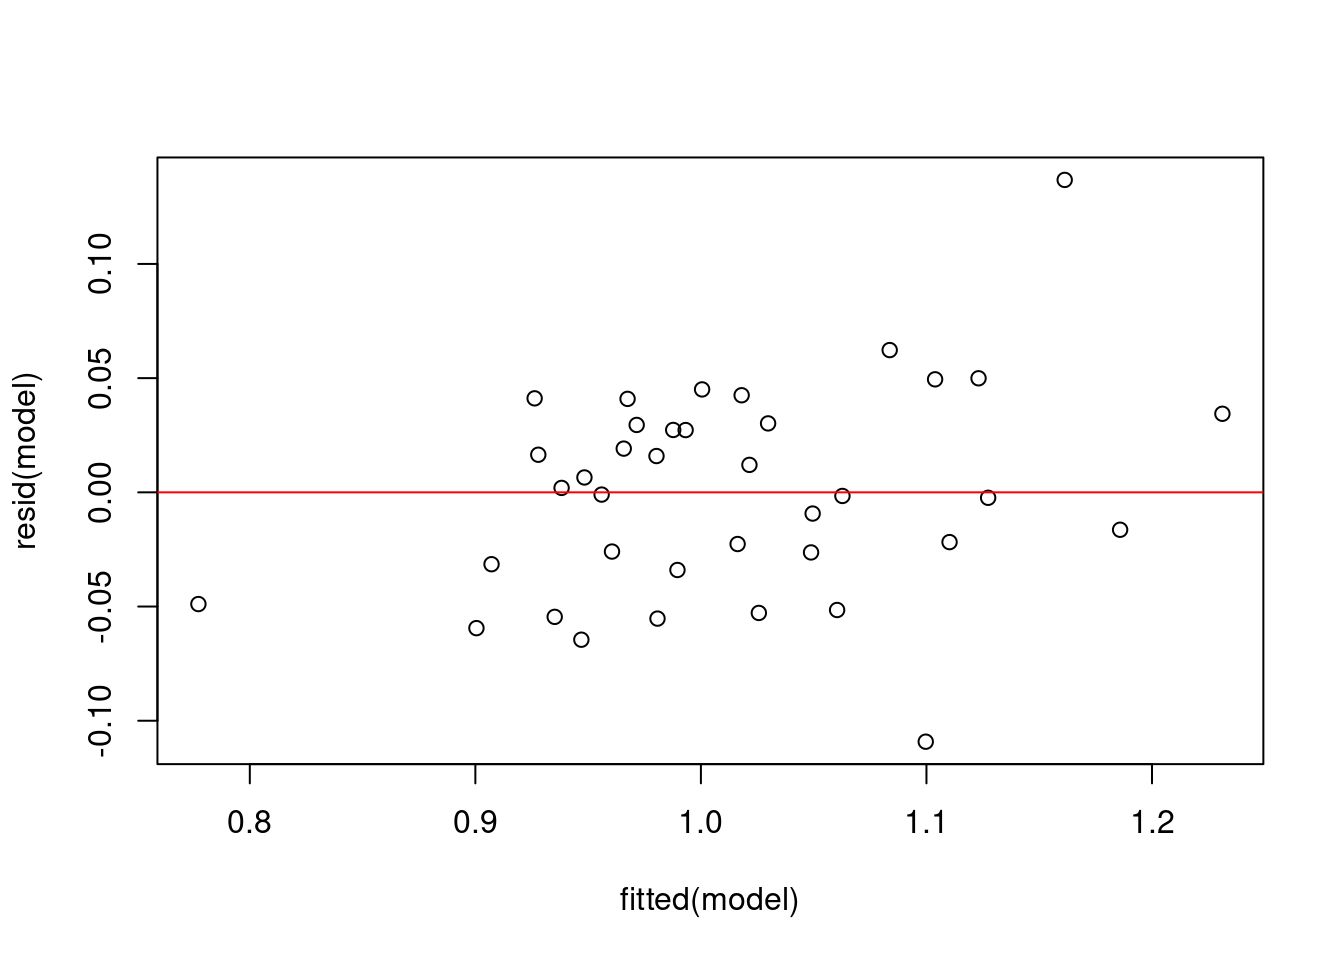

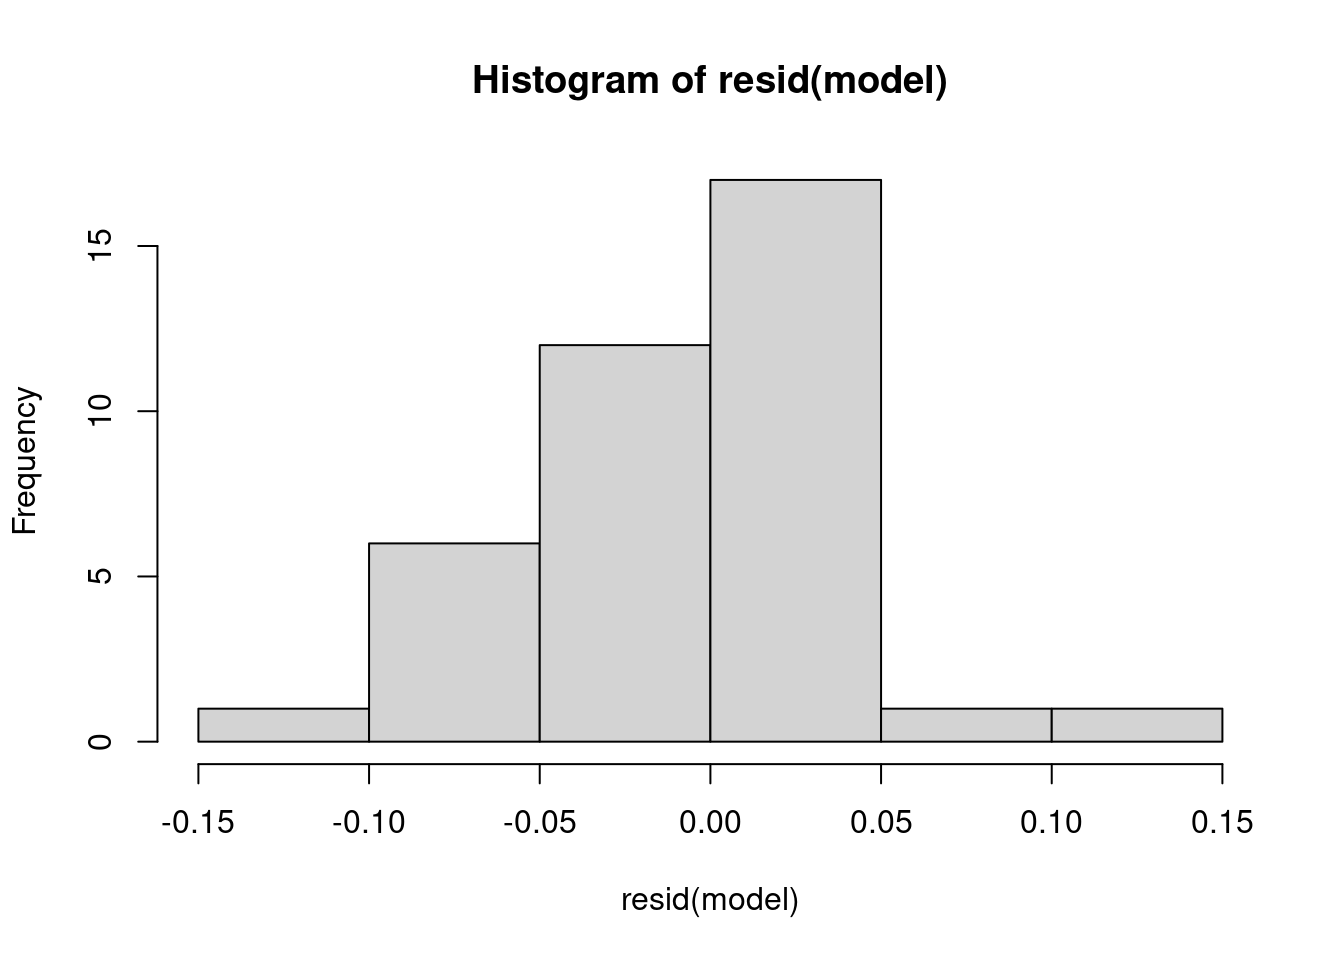

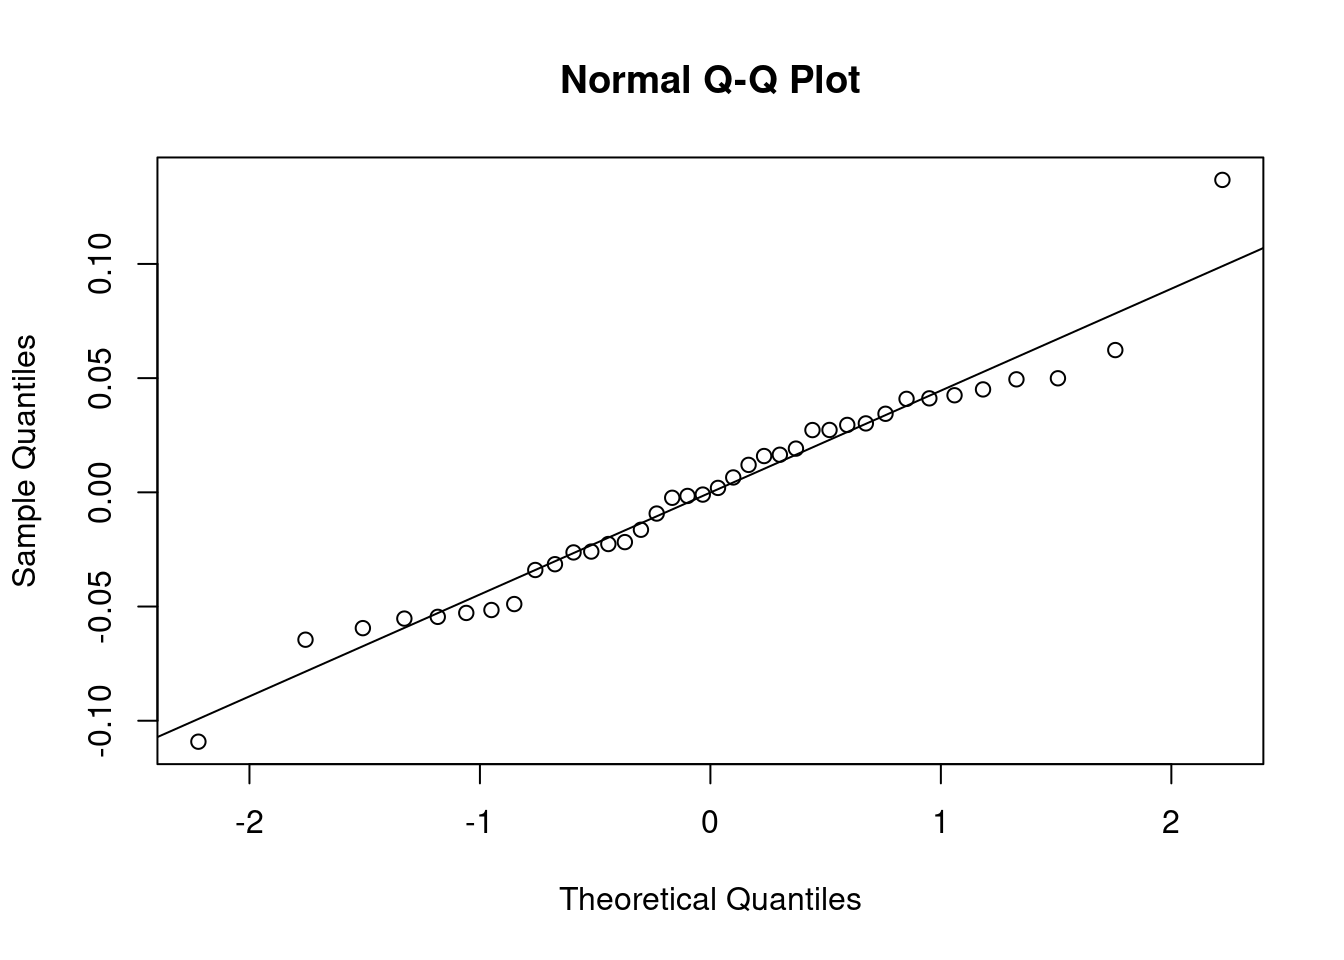

In [ ]:
# Plotting residuals to check assumptions
plot(resid(model) ~ fitted(model))
abline(h = 0, col = "red")

In [ ]:
# Comparing a simpler model without the EI predictor
model_without_EI <- lmer(Hurst ~ Age + Sex + Condition + (1 | Subject), data = df_lme)
anova(model, model_without_EI)

refitting model(s) with ML (instead of REML)

Data: df_lme
Models:
model_without_EI: Hurst ~ Age + Sex + Condition + (1 | Subject)
model: Hurst ~ EI + Age + Sex + Condition + MeanFD + (1 | Subject)
                 npar     AIC     BIC logLik deviance  Chisq Df Pr(>Chisq)
model_without_EI    6 -67.156 -57.331 39.578  -79.156                     
model               8 -65.274 -52.173 40.637  -81.274 2.1175  2     0.3469

refitting model(s) with ML (instead of REML)

Data: df_lme
Models:
model_without_Condition: Hurst ~ Age + Sex + EI + (1 | Subject)
model: Hurst ~ EI + Age + Sex + Condition + MeanFD + (1 | Subject)
                        npar     AIC     BIC logLik deviance  Chisq Df
model_without_Condition    6 -56.088 -46.263 34.044  -68.088          
model                      8 -65.274 -52.173 40.637  -81.274 13.185  2
                        Pr(>Chisq)   
model_without_Condition              
model                      0.00137 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

## Remove Spectroscopy and fMRI Outliers

In [ ]:
df_lme_nooutliers <- df_lme %>% filter(!c(Subject == 3 | Subject == 5 | Subject == 8 | Subject == 14 | Subject == 17 | Subject == 21 | Subject == 25))
model <- lmer(Hurst ~ EI + Age + Sex + Condition + (1 | Subject), data = df_lme_nooutliers)
summary(model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Hurst ~ EI + Age + Sex + Condition + (1 | Subject)
   Data: df_lme_nooutliers

REML criterion at convergence: -48.6

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.70595 -0.41418  0.06778  0.49065  2.17278 

Random effects:
 Groups   Name        Variance Std.Dev.
 Subject  (Intercept) 0.007581 0.08707 
 Residual             0.003544 0.05953 
Number of obs: 38, groups:  Subject, 19

Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    1.056825   0.118260 31.636508   8.936 3.65e-10 ***
EI             0.031192   0.029101 24.942011   1.072 0.294051    
Age           -0.003880   0.002802 16.025372  -1.385 0.185123    
SexM           0.060666   0.047360 16.023470   1.281 0.218447    
ConditionRest -0.076597   0.019339 17.310868  -3.961 0.000979 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed

# Linear Mixed Effects (Rescaled Range)

In [ ]:
df_rs_lme <- df %>%
  select(Subject, Rest_RS, Movie_RS, Rest_Glu, Movie_Glu, Rest_GABA, Movie_GABA, Rest_FWHM_SLASER, Movie_FWHM_SLASER, Rest_FWHM_Osprey, Movie_FWHM_Osprey, Rest_MeanFD, Movie_MeanFD) %>%
  rename(Rest_Hurst = Rest_RS, Movie_Hurst = Movie_RS, Rest_FWHMsLASER = Rest_FWHM_SLASER, Movie_FWHMsLASER = Movie_FWHM_SLASER, Rest_FWHMOsprey = Rest_FWHM_Osprey, Movie_FWHMOsprey = Movie_FWHM_Osprey)
subjects_lme <- subjects %>% select(Age, Subject, Sex)
df_rs_lme <- full_join(df_rs_lme, subjects_lme, by = "Subject")
df_rs_lme$Sex <- as.factor(df_rs_lme$Sex)

In [ ]:
df_rs_lme <- df_rs_lme %>% pivot_longer(
  cols = -c(Age, Sex, Subject), # Exclude the Subject column from the transformation
  names_to = c("Condition", ".value"), # Split original column names
  names_pattern = "(.*)_(.*)" # Pattern to split the original column names
)
df_rs_lme$EI <- df_rs_lme$Glu / df_rs_lme$GABA
# df_rs_lme <- df_rs_lme %>% select(-c(Glu,GABA))
df_rs_lme$Condition <- as.factor(df_rs_lme$Condition)

In [ ]:
model <- lmer(Hurst ~ EI + Age + Sex + Condition + MeanFD + (1 | Subject), data = df_rs_lme)

rescaling
rescaling

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Hurst ~ EI + Age + Sex + Condition + MeanFD + (1 | Subject)
   Data: df_rs_lme

REML criterion at convergence: -77.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7475 -0.5566  0.1651  0.5375  1.7586 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Subject  (Intercept) 0.0005128 0.02265 
 Residual             0.0019785 0.04448 
Number of obs: 38, groups:  Subject, 19

Fixed effects:
                Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    5.795e-01  5.198e-02  2.047e+01  11.148 3.77e-10 ***
EI            -5.408e-05  6.825e-05  3.032e+01  -0.792   0.4343    
Age            2.383e-03  1.183e-03  1.506e+01   2.014   0.0622 .  
SexM          -9.907e-04  1.997e-02  1.504e+01  -0.050   0.9611    
ConditionRest  1.691e-02  1.459e-02  1.761e+01   1.159   0.2620    
MeanFD         4.583e-01  3.747e-01  2.322e+01   1.223   0.2336    
---
Signif. co

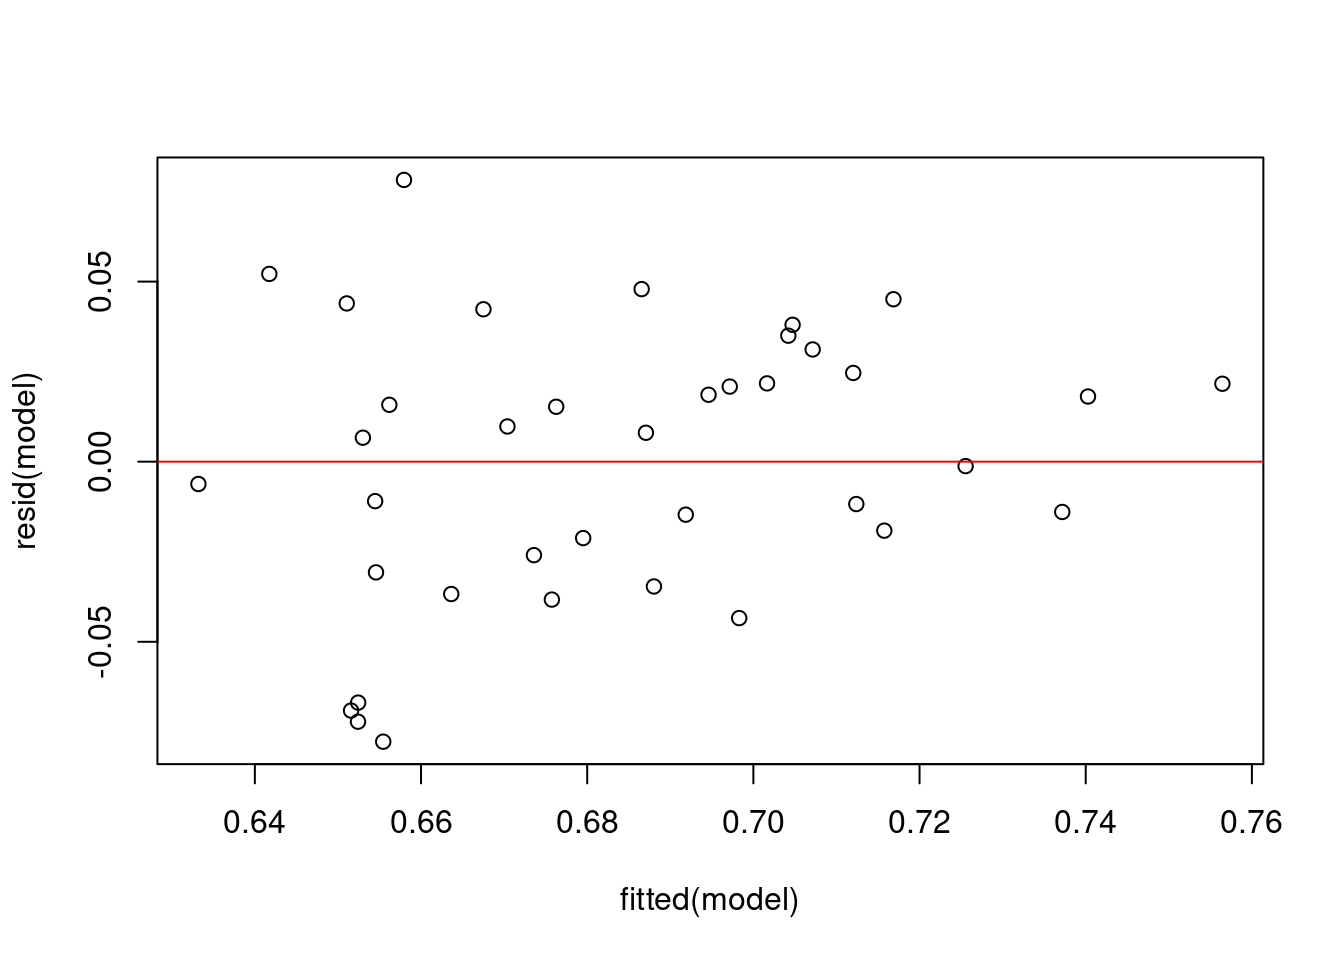

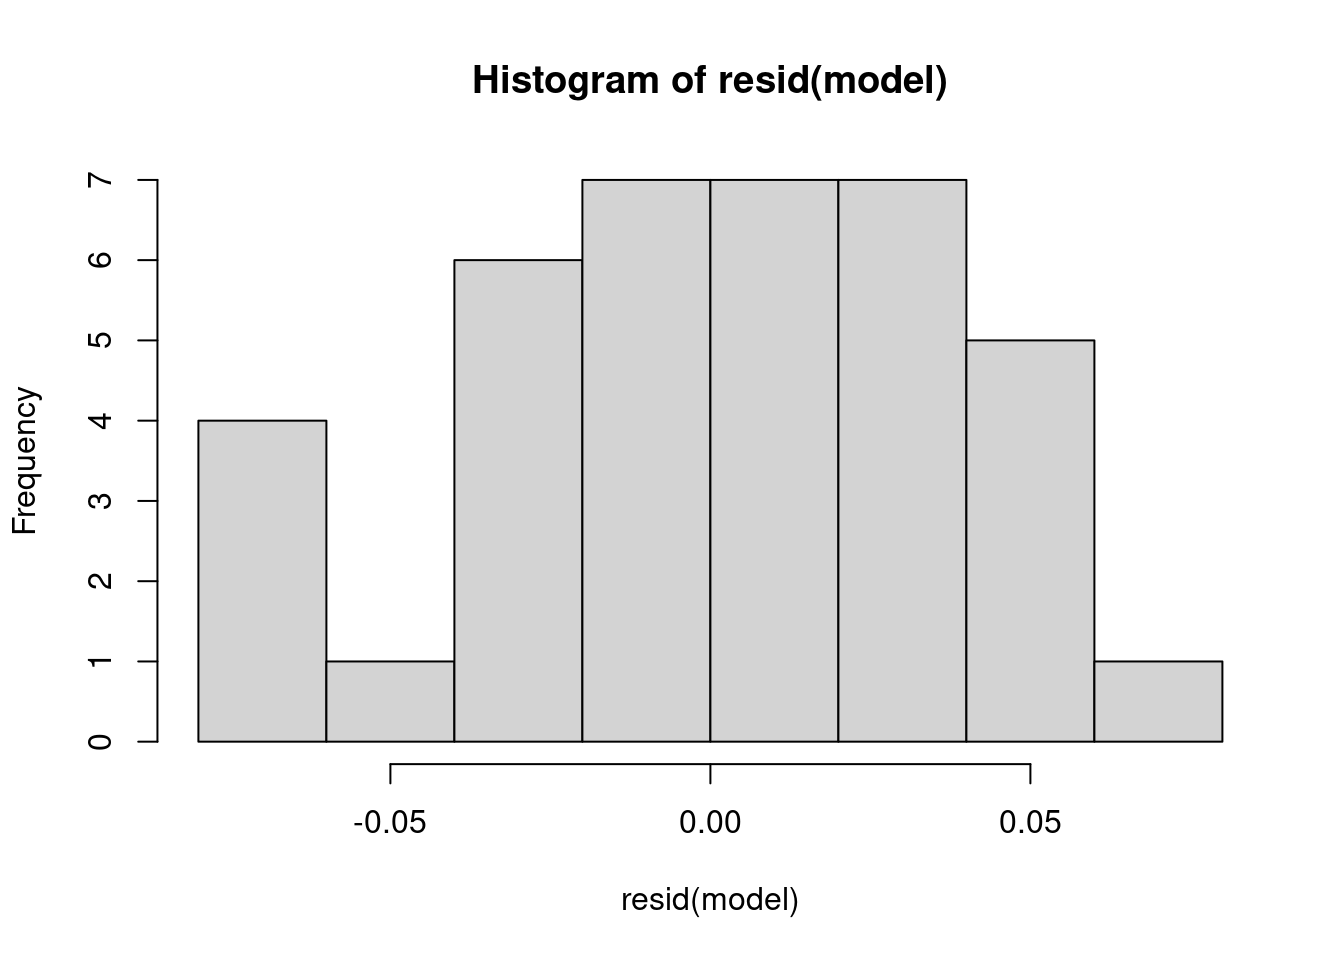

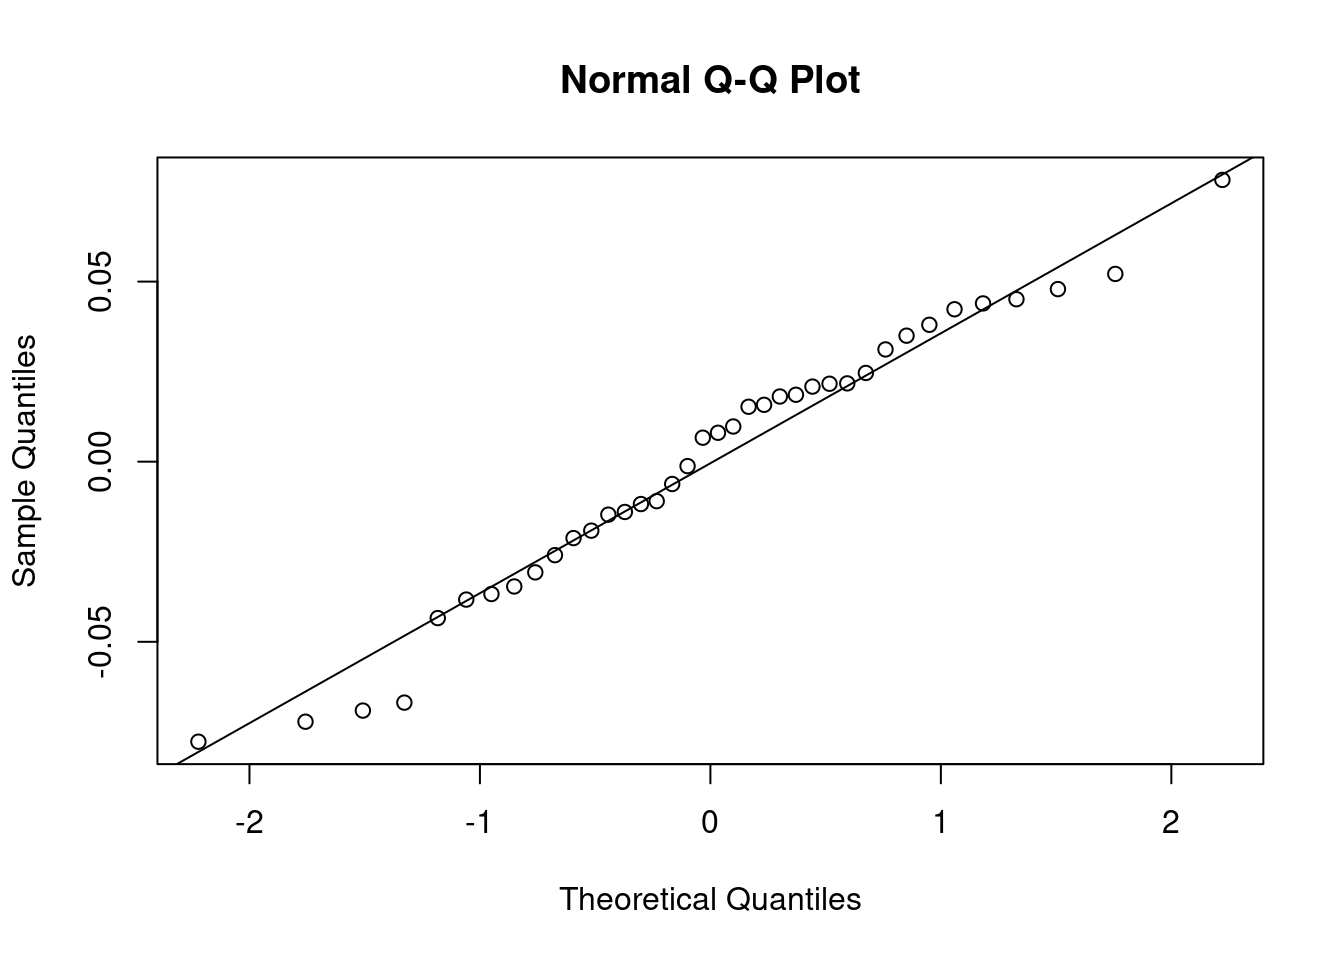

In [ ]:
# Plotting residuals to check assumptions
plot(resid(model) ~ fitted(model))
abline(h = 0, col = "red")

In [ ]:
# Comparing a simpler model without the EI predictor
model_without_EI <- lmer(Hurst ~ Age + Sex + Condition + (1 | Subject), data = df_rs_lme)
anova(model, model_without_EI)

refitting model(s) with ML (instead of REML)

Data: df_rs_lme
Models:
model_without_EI: Hurst ~ Age + Sex + Condition + (1 | Subject)
model: Hurst ~ EI + Age + Sex + Condition + MeanFD + (1 | Subject)
                 npar     AIC      BIC logLik deviance  Chisq Df Pr(>Chisq)
model_without_EI    6 -113.03 -103.200 62.513  -125.03                     
model               8 -111.47  -98.367 63.734  -127.47 2.4416  2      0.295

refitting model(s) with ML (instead of REML)

Data: df_rs_lme
Models:
model_without_Condition: Hurst ~ Age + Sex + EI + (1 | Subject)
model: Hurst ~ EI + Age + Sex + Condition + MeanFD + (1 | Subject)
                        npar     AIC      BIC logLik deviance  Chisq Df
model_without_Condition    6 -112.49 -102.664 62.245  -124.49          
model                      8 -111.47  -98.367 63.734  -127.47 2.9779  2
                        Pr(>Chisq)
model_without_Condition           
model                       0.2256

In [ ]:
df_rs_lme_nooutliers <- df_rs_lme %>% filter(!c(Subject == 3 | Subject == 5 | Subject == 8 | Subject == 14 | Subject == 17 | Subject == 21 | Subject == 25))
model <- lmer(Hurst ~ EI + Age + Sex + Condition + (1 | Subject), data = df_rs_lme_nooutliers)
summary(model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Hurst ~ EI + Age + Sex + Condition + (1 | Subject)
   Data: df_rs_lme_nooutliers

REML criterion at convergence: -75.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.90360 -0.50913  0.08424  0.57072  1.58629 

Random effects:
 Groups   Name        Variance Std.Dev.
 Subject  (Intercept) 0.000757 0.02751 
 Residual             0.001834 0.04283 
Number of obs: 38, groups:  Subject, 19

Fixed effects:
                Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    6.151e-01  4.450e-02  2.283e+01  13.823  1.4e-12 ***
EI            -4.829e-05  6.904e-05  3.247e+01  -0.699   0.4893    
Age            2.839e-03  1.185e-03  1.576e+01   2.396   0.0294 *  
SexM          -8.264e-03  2.011e-02  1.587e+01  -0.411   0.6866    
ConditionRest  1.429e-02  1.390e-02  1.777e+01   1.028   0.3177    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Corre

In [ ]:
save.image('results.RData')